# Udacity Capstone Project - Starbucks Offer Analytics

### Introduction
We will leverage what we’ve learned throughout the program to build a data science project, for Starbucks Offer Analytics.

We will follow the **six CRISP-DM** phases for the project. CRoss Industry Standard Process for Data Mining (CRISP-DM) is a process model that serves as the base for a data science process which has six sequential phases, which will step through.

# 1. Business understanding¶

### Overview

This data set contains simulated data that mimics customer behavior on the Starbucks  rewards mobile app. Once every few days, Starbucks  sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Our task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. We'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

We are given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

We need to keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

We'll  want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.


### Objective is to find answers to below questions:

- Q1: Build a machine learning model that predicts how much someone will spend based on demographics and offer type.
- Q2: Determine which demographic groups respond best to which offer type.
- Q3: Build a model that predicts whether or not someone will respond to an offer. 

# -----------------------------------------------------------------------------------------------------------

# 2. Data understanding

We are given the data in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, **in days**
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in **hours** since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


#### Let's dive in. We will define utility functions as needed along the way.


In [1]:
# libraries used
import pandas as pd
from pandas.plotting import scatter_matrix

import numpy as np
import math
import json
from datetime import datetime
import scipy.stats as stats

from sklearn.metrics import confusion_matrix, silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LassoCV, LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier

from sklearn.cluster import KMeans
import pickle
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

# global PRINT variable to suppress print
PRINT = False
# gobal purchase_high_limit for outliers
purchase_high_limit = 1200.00

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 3. Data preparation
From the initial analysis below we see need to clean up the data for missing values or dropping unneeded attributes. We will organize the data for modeling by selecting few variables, impute missing data in them, and format them. We will create dummy variables for relevant categorical variables. First build some utility functions that we can use, some of these function were created as needed but during refactoring, moved them up top.


In [3]:
def printf(*args, **kwargs):
    """
    Utility function, extends the built-in print function, but only prints if the global variable PRINT is True.
    Parameters:
    *args: Any number of positional arguments to be passed to print.
    **kwargs: Any keyword arguments to be passed to print.
    """
    if PRINT:
        print(*args, **kwargs)

In [4]:
def info_on_df(df):
    """
    Utility function to prints the shape and column names of a given pandas DataFrame.
    Parameters:
        df : The DataFrame to obtain information about.
    Returns:
        None
    """
    print('------------------------------------')
    print("Shape of DataFrame:", df.shape)
    print("Columns of DataFrame:", df.columns)

In [5]:
def create_missing_values_table(df):
    '''
    This function provides stats on missing values on a given dataframe
    Parameters
    df - dataframe
    Returns
    dataframe that has missing value stats for each column in the input dataframe, including data types,
    number of missing values, and percentage of missing values
    '''
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # data types of those columns with missing values
    mis_dtypes = df[df.isnull()].dtypes

    # Make a table with the results
    mis_val_table = pd.concat([mis_dtypes, mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns={
        0: 'DataTypes',
        1: 'Missing Values',
        2: '% of Total Values'
    })

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
            '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
          "----------------------------------------------------\nThere are " +
          str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [6]:
def remove_outliers(df, column):
    """
    Utility function to remove outliers from a DataFrame based on the specified column.
    Parameters:
    df : The DataFrame containing the data to remove outliers from.
    column : str, name of the column to remove outliers from.
    Returns: new DataFrame with the outliers removed.
    """
    print("\n---In function remove_outliers ---\n")
    info_on_df(df)
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    df_clean = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    # find how many rows are left in the dataframe
    info_on_df(df_clean)
    print("\n---Leaving function remove_outliers ---\n")
    return df_clean

In [7]:
def plot_histogram(df, title, col, nbins=18):
    """
    Utility function to plot histogram using DataFrame and gives passed Title.
    Parameters:
    df :  DataFrame containing the data to plot histogram.
    title: str, title of the histgram.
    Returns: none.
    """
    counts, edges, bars = plt.hist(df[col], bins=nbins)
    plt.xlabel(col)
    plt.ylabel('Counts')
    plt.title(title)
    plt.bar_label(bars)

In [8]:
def create_dummy_variables(df, column_name, prfx=''):
    """
    Utility function to reate dummy variables for each value in a column (containing multiple values) with a given prefix.
    Parameters:
        df :  DataFrame containing the column to be transformed.
        column_name :  name of the column to be transformed.
        prfx : prefix to use for dummy variables
    Returns:
        df : A new DataFrame with one column for each unique value in the original column, with dummy variables
        set to 1 if the original column contained that value.
    """
    # create dummy variable for the column_name in df
    df_dummies = pd.get_dummies(df[column_name], prefix=prfx)
    df2 = pd.concat([df, df_dummies], axis=1)

    # Drop the offer_type since we have the dummy vars
    df2 = df2.drop([column_name], axis=1)

    return df2

## Let's analyze the profile dataset:

In [9]:
#Let's see the profile data & strcuture
printf("profile Sample Data:\n", profile.head())

printf("\n profile info: \n", profile.info())

printf("\n profile summary stats:\n", profile.describe(include='all'))

# Call create_missing_values_table function with profile df
create_missing_values_table(profile)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB
Your selected dataframe has 5 columns.
----------------------------------------------------
There are 2 columns that have missing values.


,DataTypes,Missing Values,% of Total Values
gender,object,2175,12.8
income,float64,2175,12.8


#### There are about 13% missing gender and income values.

In [10]:
# Let's see the breakdown of missing values in gender
profile["gender"].value_counts(dropna=False) / profile.shape[0]

M       0.499059
F       0.360529
None    0.127941
O       0.012471
Name: gender, dtype: float64

In [11]:
# fill missing values in gender with U as in unknown since they are signifiant proportation.
profile.fillna(value={"gender": "U"}, inplace=True)

# Call create_missing_values_table function with profile df
create_missing_values_table(profile)

Your selected dataframe has 5 columns.
----------------------------------------------------
There are 1 columns that have missing values.


,DataTypes,Missing Values,% of Total Values
income,float64,2175,12.8


In [12]:
# let's see the average income by gender
profile[['gender', 'income']].groupby(by="gender", dropna=False).mean()

,income
gender,
F,71306.412139
M,61194.601603
O,63287.735849
U,NaN


count     16999.000000
mean      65439.761162
std       20946.694159
min       30000.000000
25%       50000.000000
50%       64000.000000
75%       79000.000000
max      120000.000000
Name: income, dtype: float64


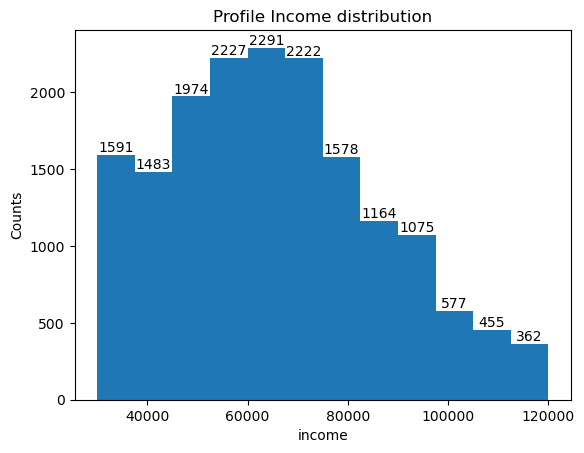

In [13]:
# These missing values can be imputed to average income for each gender subset
profile.loc[profile['gender'] == 'M',
            'income'] = profile.loc[profile['gender'] == 'M',
                                    'income'].interpolate(method='linear')
profile.loc[profile['gender'] == 'F',
            'income'] = profile.loc[profile['gender'] == 'F',
                                    'income'].interpolate(method='linear')

profile.loc[profile['gender'] == 'O',
            'income'] = profile.loc[profile['gender'] == 'O',
                                    'income'].interpolate(method='linear')

# for remaining, gender= U we will use entire dataset to impute income
profile['income'].interpolate(method='linear', inplace=True)

print(profile['income'].describe())

# let's see the income distribution histogram
plot_histogram(profile, 'Profile Income distribution', 'income', nbins=12)

<AxesSubplot: title={'center': 'Profile boxplot for income'}>

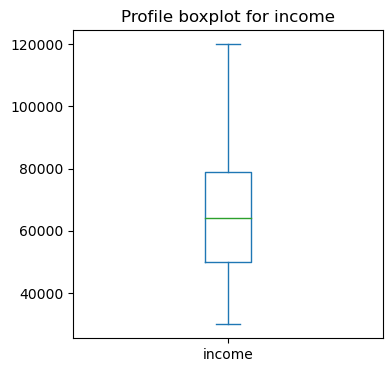

In [14]:
# lets check if there are any outliers in income
profile["income"].plot.box(title="Profile boxplot for income", figsize=(4, 4))

### Boxplot above does not show any outliers in the income variable.

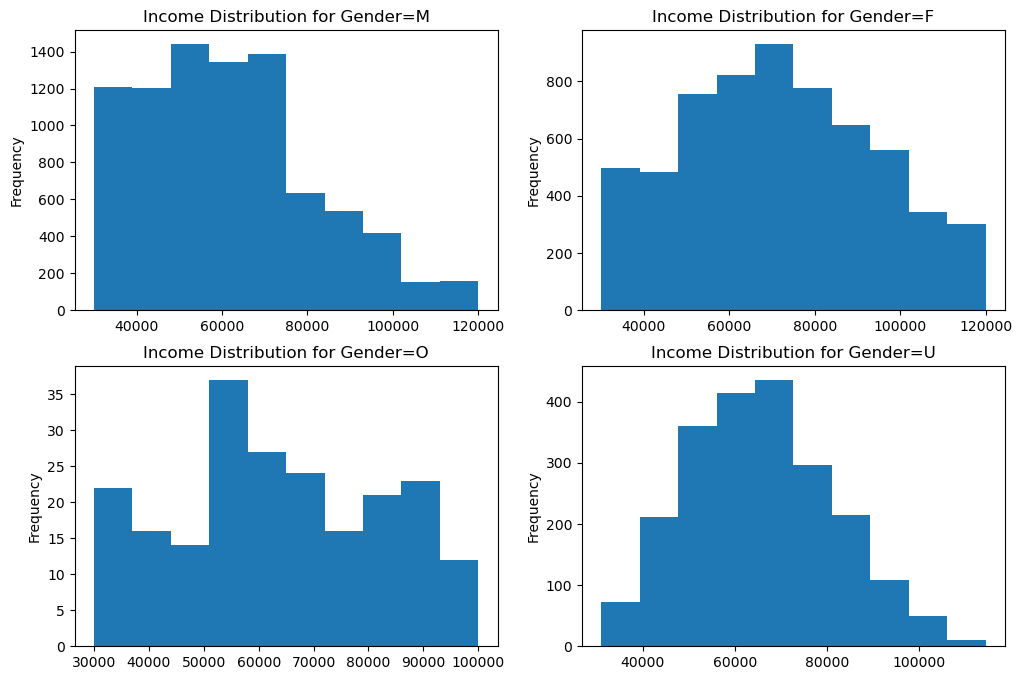

In [15]:
# let's see the income distribution by gender
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
profile[profile["gender"] == 'M']['income'].plot.hist(
    ax=axs[0, 0], title="Income Distribution for Gender=M")
profile[profile["gender"] == 'F']['income'].plot.hist(
    ax=axs[0, 1], title="Income Distribution for Gender=F")
profile[profile["gender"] == 'O']['income'].plot.hist(
    ax=axs[1, 0], title="Income Distribution for Gender=O")
profile[profile["gender"] == 'U']['income'].plot.hist(
    ax=axs[1, 1], title="Income Distribution for Gender=U")
plt.show()

For genders F and U the income distribution appears to be normal while for gender O it does not. For gender M it appears to be skewed to left. Notice gender F has more cusomters in income 100K or more range compared to others.

In [16]:
def create_income_bins(df):
    '''
    This function will create income dummy variables for each bin in the specified range.
    input - dataframe
    returns - dataframe with dummy variables for "income" variable without original variable.
    '''
    bins = pd.cut(df['income'], [
        10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000,
        110000, 120000, np.inf
    ],
                  labels=[
                      '0_20k', '20_30k', '30_40k', '40_50k', '50_60k',
                      '60_70k', '70_80k', '80_90k', '90_100k', '100_110k',
                      '110_120k', '120+'
                  ])
    df = pd.concat([df, pd.get_dummies(bins, prefix='income')], axis=1)
    df = df.drop(['income'], axis=1)
    return df

In [17]:
# create income dummy variables
profiledf1 = create_income_bins(profile)
info_on_df(profiledf1)

------------------------------------
Shape of DataFrame: (17000, 16)
Columns of DataFrame: Index(['gender', 'age', 'id', 'became_member_on', 'income_0_20k',
       'income_20_30k', 'income_30_40k', 'income_40_50k', 'income_50_60k',
       'income_60_70k', 'income_70_80k', 'income_80_90k', 'income_90_100k',
       'income_100_110k', 'income_110_120k', 'income_120+'],
      dtype='object')


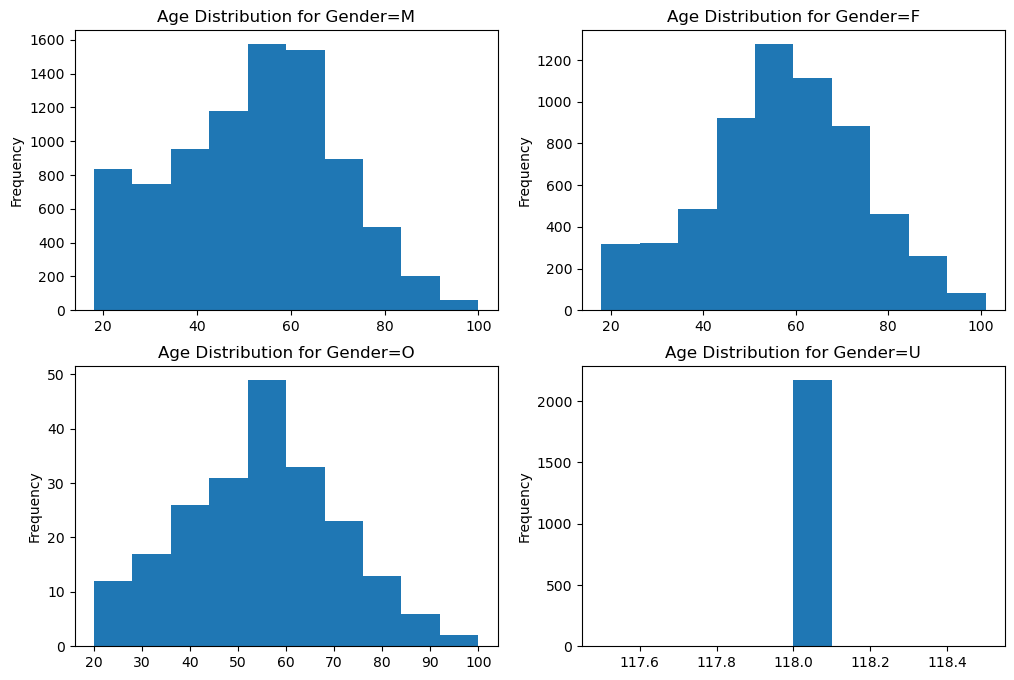

In [18]:
# let's see the age distribution by gender
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
profiledf1[profiledf1["gender"] == 'M']['age'].plot.hist(
    ax=axs[0, 0], title="Age Distribution for Gender=M")
profiledf1[profiledf1["gender"] == 'F']['age'].plot.hist(
    ax=axs[0, 1], title="Age Distribution for Gender=F")
profiledf1[profiledf1["gender"] == 'O']['age'].plot.hist(
    ax=axs[1, 0], title="Age Distribution for Gender=O")
profiledf1[profiledf1["gender"] == 'U']['age'].plot.hist(
    ax=axs[1, 1], title="Age Distribution for Gender=U")
plt.show()

We see more than 2000 observations with unknown gender have age over 100 years. Most likely customers chose not  to disclose gender as well as age. Since this is significant portion (12.8%) of the data, we will leave it as is.

In [19]:
# Let's see the if there are missing values in became_member_on; Call create_missing_values_table function
create_missing_values_table(profiledf1)

# Let's see the counts of members by there membership begin date
profiledf1['became_member_on'].value_counts().sort_values(ascending=False)

Your selected dataframe has 16 columns.
----------------------------------------------------
There are 0 columns that have missing values.


20171207    43
20170819    42
20171007    40
20171113    39
20170928    38
            ..
20140228     1
20150407     1
20141128     1
20131117     1
20130922     1
Name: became_member_on, Length: 1716, dtype: int64

<AxesSubplot: title={'center': 'Profile Boxplot for became_member_on'}>

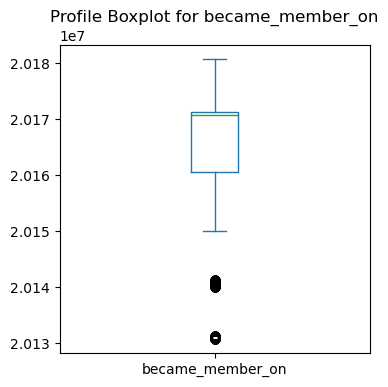

In [20]:
# We see old dates from 2013 above; let's see boxplot:
profiledf1['became_member_on'].plot.box(
    title="Profile Boxplot for became_member_on", figsize=(4, 4))

Even though we see outliers on the above boxplot for the became_member_on, we will leave them since these customers could have been members from long time ago and they are still using the app.  Calculate tenure based on the became_member_on and create tenure bins:

In [21]:
def create_member_tenure_days(df):
    '''
    This function creates a new column member_tenure_days based on "became_member_on" by calculating the 
    difference between the became_member_on and 2018-08-01 date which is closest to the max date 
    for the became_member_on. For missing became_member_on, assign None to that record.
    Parameters:
    input - dataframe
    returns - dataframe with new variables for "member_tenure_days" variable without original variable.
    '''
    # create became_member_on_date column
    df['became_member_on_date'] = pd.to_datetime(df['became_member_on'],
                                                 format='%Y%m%d',
                                                 errors='coerce')

    print("Latest date someone became a member=",
          df["became_member_on_date"].max())

    # 2018-07-26 is the max date for the became_member_on
    # not using datetime.now() since using today's date will increse the tenure to
    # unrealistic level

    todey = pd.to_datetime('20180801', format='%Y%m%d', errors='coerce')

    # compute member_tenure_days
    df.loc[df['became_member_on_date'].notna(),
           'member_tenure_days'] = (todey -
                                    df['became_member_on_date']).dt.days

    df = df.drop(['became_member_on', 'became_member_on_date'], axis=1)
    return df

In [22]:
# call the function to create the tenure days on became_member_on
profiledf2a = create_member_tenure_days(profiledf1)

info_on_df(profiledf2a)

Latest date someone became a member= 2018-07-26 00:00:00
------------------------------------
Shape of DataFrame: (17000, 16)
Columns of DataFrame: Index(['gender', 'age', 'id', 'income_0_20k', 'income_20_30k', 'income_30_40k',
       'income_40_50k', 'income_50_60k', 'income_60_70k', 'income_70_80k',
       'income_80_90k', 'income_90_100k', 'income_100_110k', 'income_110_120k',
       'income_120+', 'member_tenure_days'],
      dtype='object')


C:\Users\Admin\AppData\Local\Temp\ipykernel_10680\2848625246.py:25: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[df['became_member_on_date'].notna(),


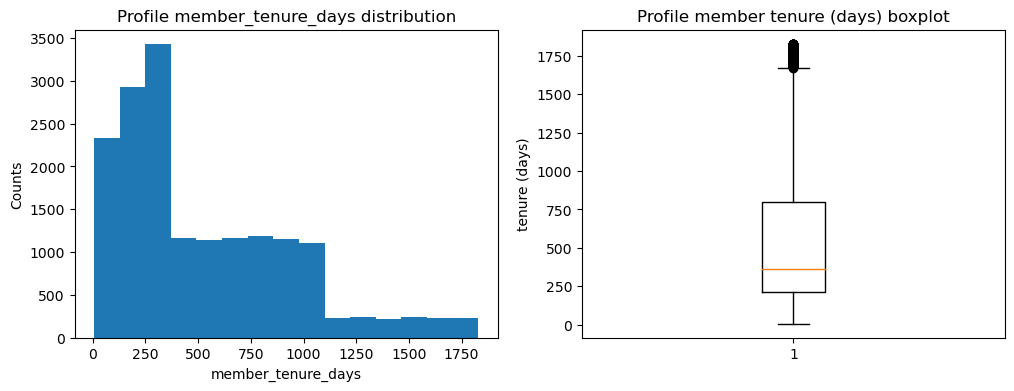

In [23]:
# let's see the member_tenure_days distribution histogram
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))

ax1.hist(profiledf2a['member_tenure_days'], bins=15)
ax1.set_title('Profile member_tenure_days distribution')
ax1.set_xlabel('member_tenure_days')
ax1.set_ylabel('Counts')

# boxplot for outliers in member_tenure_days
ax2.boxplot(profiledf2a['member_tenure_days'])
ax2.set_title('Profile member tenure (days) boxplot')
ax2.set_ylabel('tenure (days)')

plt.show()

#### Based on member_tenure_days distribution and boxplot above, we will create 11 bins since members over 270 days (median) are large in number; we consider them as loyal, and hopefully may not need regular offers.

In [24]:
def create_member_tenure_bins(df):
    '''
    This function creates dummy variables for tenure_days.
    input - dataframe
    returns - dataframe with dummy variables for "member_tenure" variable without 
    original variable.
    '''
    # create bins on member_tenure_days
    bins = pd.cut(df['member_tenure_days'],
                  [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 365, np.inf],
                  labels=[
                      '0_30', '30_60', '60_90', '90_120', '120_150', '150_180',
                      '180_210', '210_240', '240_270', '270_365', '365+'
                  ])
    df = pd.concat([df, pd.get_dummies(bins, prefix='tenure_days')], axis=1)
    df = df.drop(['member_tenure_days'], axis=1)

    return df

In [25]:
# call the function to create the tenure bins on became_member_on
profiledf2 = create_member_tenure_bins(profiledf2a)

info_on_df(profiledf2)

profiledf2.describe(include='all')

------------------------------------
Shape of DataFrame: (17000, 26)
Columns of DataFrame: Index(['gender', 'age', 'id', 'income_0_20k', 'income_20_30k', 'income_30_40k',
       'income_40_50k', 'income_50_60k', 'income_60_70k', 'income_70_80k',
       'income_80_90k', 'income_90_100k', 'income_100_110k', 'income_110_120k',
       'income_120+', 'tenure_days_0_30', 'tenure_days_30_60',
       'tenure_days_60_90', 'tenure_days_90_120', 'tenure_days_120_150',
       'tenure_days_150_180', 'tenure_days_180_210', 'tenure_days_210_240',
       'tenure_days_240_270', 'tenure_days_270_365', 'tenure_days_365+'],
      dtype='object')


,gender,age,id,income_0_20k,income_20_30k,income_30_40k,income_40_50k,income_50_60k,income_60_70k,income_70_80k,...,tenure_days_30_60,tenure_days_60_90,tenure_days_90_120,tenure_days_120_150,tenure_days_150_180,tenure_days_180_210,tenure_days_210_240,tenure_days_240_270,tenure_days_270_365,tenure_days_365+
count,17000,17000.000000,17000,17000.0,17000.000000,17000.000000,17000.0000,17000.000000,17000.000000,17000.000000,...,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
unique,4,NaN,17000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,M,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,8484,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,62.531412,NaN,0.0,0.005176,0.125941,0.1280,0.185118,0.168235,0.153118,...,0.033118,0.032765,0.035647,0.034118,0.033824,0.045294,0.051235,0.048824,0.158412,0.497882
std,NaN,26.738580,NaN,0.0,0.071763,0.331793,0.3341,0.388404,0.374086,0.360111,...,0.178949,0.178025,0.185414,0.181537,0.180780,0.207955,0.220484,0.215505,0.365137,0.500010
min,NaN,18.000000,NaN,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,45.000000,NaN,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,58.000000,NaN,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,73.000000,NaN,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [26]:
# Convert gender categorical var to dummies
profiledf3 = create_dummy_variables(profiledf2, 'gender', 'gender')

info_on_df(profiledf3)

------------------------------------
Shape of DataFrame: (17000, 29)
Columns of DataFrame: Index(['age', 'id', 'income_0_20k', 'income_20_30k', 'income_30_40k',
       'income_40_50k', 'income_50_60k', 'income_60_70k', 'income_70_80k',
       'income_80_90k', 'income_90_100k', 'income_100_110k', 'income_110_120k',
       'income_120+', 'tenure_days_0_30', 'tenure_days_30_60',
       'tenure_days_60_90', 'tenure_days_90_120', 'tenure_days_120_150',
       'tenure_days_150_180', 'tenure_days_180_210', 'tenure_days_210_240',
       'tenure_days_240_270', 'tenure_days_270_365', 'tenure_days_365+',
       'gender_F', 'gender_M', 'gender_O', 'gender_U'],
      dtype='object')


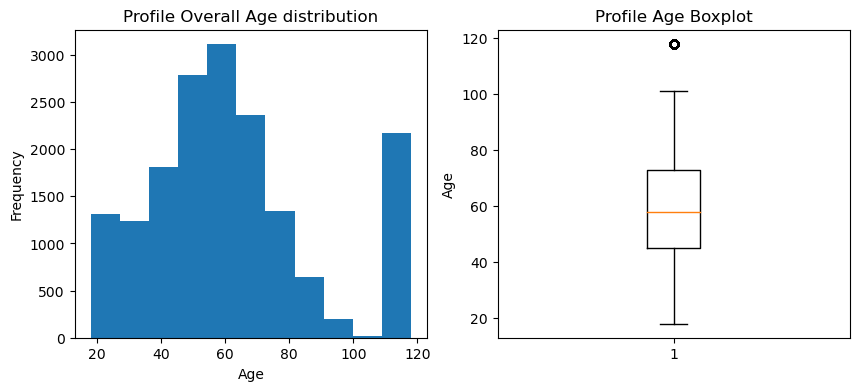

In [27]:
# let's see the age distribution via histogram and outliers via boxplot
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

# Age - Histogram
ax1.hist(profiledf3['age'], bins=11)
ax1.set_title('Profile Overall Age distribution')
ax1.set_xlabel('Age')
ax1.set_ylabel('Frequency')

# Age - Boxplot
ax2.boxplot(profiledf3['age'])
ax2.set_title('Profile Age Boxplot')
ax2.set_ylabel('Age')

plt.show()

There are 2000+ customers aged 100+ years, and identified as outlier but probably customers just chose the max age that was available while setting up the profile in the app. We will keep them in the data, and create a separate bin for that group as below:

In [28]:
def create_age_bins(df):
    '''
    This function will create age dummy variables for each bin in the 10 year increments, 70-100, and 100+ year.
    parameters:
    input - dataframe
    returns - dataframe with dummy variables for "age" variable without original variable.
    '''
    bins = pd.cut(df['age'], [10, 20, 30, 40, 50, 60, 70, 100, np.inf],
                  labels=[
                      '0_20y', '20_30y', '30_40y', '40_50y', '50_60y',
                      '60_70y', '70_100y', '100+'
                  ])
    df = pd.concat([df, pd.get_dummies(bins, prefix='age')], axis=1)
    df = df.drop(['age'], axis=1)
    return df

In [29]:
# call the function to create age bins
profiledf4 = create_age_bins(profiledf3)
info_on_df(profiledf4)

# double check if there are any missing values.
create_missing_values_table(profiledf4)

------------------------------------
Shape of DataFrame: (17000, 36)
Columns of DataFrame: Index(['id', 'income_0_20k', 'income_20_30k', 'income_30_40k', 'income_40_50k',
       'income_50_60k', 'income_60_70k', 'income_70_80k', 'income_80_90k',
       'income_90_100k', 'income_100_110k', 'income_110_120k', 'income_120+',
       'tenure_days_0_30', 'tenure_days_30_60', 'tenure_days_60_90',
       'tenure_days_90_120', 'tenure_days_120_150', 'tenure_days_150_180',
       'tenure_days_180_210', 'tenure_days_210_240', 'tenure_days_240_270',
       'tenure_days_270_365', 'tenure_days_365+', 'gender_F', 'gender_M',
       'gender_O', 'gender_U', 'age_0_20y', 'age_20_30y', 'age_30_40y',
       'age_40_50y', 'age_50_60y', 'age_60_70y', 'age_70_100y', 'age_100+'],
      dtype='object')
Your selected dataframe has 36 columns.
----------------------------------------------------
There are 0 columns that have missing values.


,DataTypes,Missing Values,% of Total Values


# Create demographic clusters on profiledf4:

We started with just 4 customer demographic attributes in profile and with binning and dummy variables, we now have 36 variables! One way to reduce the variables for analysis is to group them in clusters using KMeans clustering model. First we find an optimal number of clusters using Silhouette, Calinski-Harabasz, and Davies Bouldin scores and then use that number to create and assign clusters to the customers in the profile dataset.

In [30]:
# create a function to find the optimal number of clusters using different scores
def find_optimal_numclusters(X_train_arr, min_clusters=4, max_clusters=16):
    """
    Finds the optimal number of clusters using KMeans clustering for a given dataset.
    Parameters:
    X_train_arr : Array containing the data points for clustering
    min_clusters : int, optional, default 4 ; Minimum number of clusters to try
    max_clusters : int, optional, default 16 ; Maximum number of clusters to try
    Returns:
    df_scores : DataFrame containing the clustering scores for different numbers of clusters
    """
    # scale the data
    scaler = StandardScaler(with_mean=True)
    scaler.fit(X_train_arr)

    # step to find optimal number of clusters
    seed_random = 42
    fitted_kmeans = {}
    labels_kmeans = {}
    df_scores = []
    k_values_to_try = np.arange(min_clusters, max_clusters)

    for n_clusters in k_values_to_try:
        #Perform clustering.
        kmeans = KMeans(n_clusters=n_clusters,
                        random_state=seed_random,
                        verbose=0)

        labels_clusters = kmeans.fit_predict(X_train_arr)

        #Insert fitted model and calculated cluster labels in dictionaries,
        #for further reference.
        fitted_kmeans[n_clusters] = kmeans
        labels_kmeans[n_clusters] = labels_clusters

        #Calculate various scores, and save them for further reference.
        silhouette = silhouette_score(X_train_arr, labels_clusters)
        ch = calinski_harabasz_score(X_train_arr, labels_clusters)
        db = davies_bouldin_score(X_train_arr, labels_clusters)
        tmp_scores = {
            "n_clusters": n_clusters,
            "silhouette_score": silhouette,
            "calinski_harabasz_score": ch,
            "davies_bouldin_score": db,
        }
        df_scores.append(tmp_scores)

    #Create a DataFrame of clustering scores, using `n_clusters` as index, for easier plotting.
    df_scores = pd.DataFrame(df_scores)
    df_scores.set_index("n_clusters", inplace=True)

    # Elbow plot
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    df_scores["silhouette_score"].plot(ax=axs[0],
                                       title="silhouette_score, higher better")
    df_scores["calinski_harabasz_score"].plot(
        ax=axs[1], title="calinski_harabasz_score, higher better")
    df_scores["davies_bouldin_score"].plot(
        ax=axs[2], title="davies_bouldin_score, lower better")

    plt.show()

    return df_scores

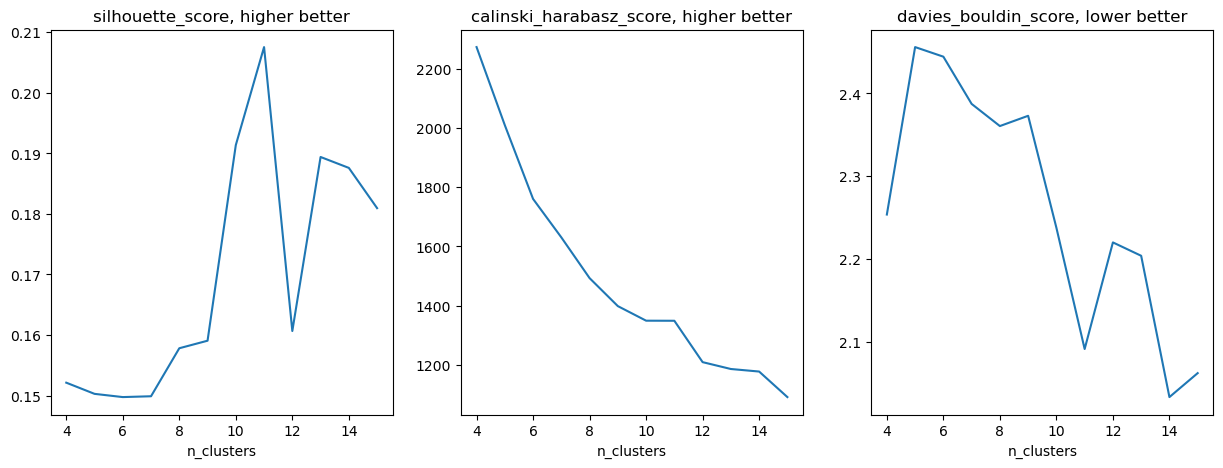

,silhouette_score,calinski_harabasz_score,davies_bouldin_score
n_clusters,,,
4,0.152134,2273.390185,2.253770
5,0.150287,2009.553418,2.455884
6,0.149754,1760.283616,2.444302
7,0.149890,1630.331800,2.387309
8,0.157818,1492.679439,2.360562
9,0.159063,1398.093165,2.372950
10,0.191366,1348.855527,2.237824
11,0.207549,1348.589617,2.091470
12,0.160665,1208.784373,2.220134


In [31]:
# make a copy of profiledf4, drop id column
profiledf5 = profiledf4.drop(["id"], axis=1)

# call the function to find the optimal number of clusters
PRINT = True
df_cluster_scores = find_optimal_numclusters(profiledf5,
                                             min_clusters=4,
                                             max_clusters=16)
# Review scores from the function
df_cluster_scores

From the plots above, we don't see a clear "elbow" point in the Silhouette or Calinski-Harabasz scores. The Silhouette score and Calinski-Harabasz score are highest for 11 clusters, while the Davies-Bouldin score is lowest for 11 clusters. So 11 clusters is a reasonable choice.
#### Let's go with 11 clusters since thru iteration, observed that with 8 and 10 clusters, cluster1 has highest number of customers making them skewed, especially the models predicting the clusters .

In [32]:
# Let's create a variable for number of clusters and define a function to create that many clusters
NumClusters = 11

In [33]:
def create_clusters_on_df(X_train, numClusters=8):
    """
    Applies KMeans clustering to the input data and returns the predicted cluster labels 
    for each data point.
    Parameters:
        X_train (DataFrame): Input data to apply clustering to.
        numClusters (int): Number of clusters to generate (default is 8).
    Returns:
        y_train_pred (ndarray): Predicted cluster labels for each data point.
        X_train_pred_clusterdf (DataFrame): cluster centers for each cluster
        modelkm : kmeans model itself
    """
    # convert df to an array for KMeans
    X_train_arr = np.array(X_train)
    printf("X_train_arr.shape:", X_train_arr.shape)

    # fit the kmeans model to X_train_arr data
    modelkm = KMeans(n_clusters=numClusters, verbose=0,
                     random_state=42).fit(X_train_arr)

    # printf max modelkm labels
    printf("no. clusters X_train:", max(modelkm.labels_) + 1)

    # let's predict k-means clustering on X_train_arr
    y_train_pred = modelkm.predict(X_train_arr)
    printf("y_train_pred shape:", y_train_pred.shape)

    # what are the cluster centers
    printf("Cluster centers:\n", modelkm.cluster_centers_.shape)

    # Store cluster centers as DF; add column names; transpose and round values to 2
    # after decimal
    X_train_pred_clusterdf = pd.DataFrame(
        modelkm.cluster_centers_, columns=X_train.columns).transpose().apply(
            lambda x: np.abs(round(x, 2)))

    # Name the clusters
    cols = ['cluster{}'.format(i + 1) for i in range(numClusters)]
    X_train_pred_clusterdf.columns = cols

    # printf cluster details
    X_train_pred_clusterdf.sort_values(by=cols, ascending=False, inplace=True)
    printf(X_train_pred_clusterdf)

    return y_train_pred, X_train_pred_clusterdf, modelkm

In [34]:
def save_model(model, model_filepath):
    '''
    Saves model to a file as pklfile
    Parameters:
        model: model 
        model_filepath : string that has file path to store the model
    Returns:
        none
    '''
    with open(model_filepath, 'wb') as pklfile:
        pickle.dump(model, pklfile)

#### Call the function to predict the clusters on profile df5

In [35]:
PRINT = False
# call the function to predict the clusters
profiledf5_cluster_pred, X_train_pred_clusterdf, modelkm = create_clusters_on_df(
    profiledf5, NumClusters)

# Save the model to a file
filepath = 'modelkmeans.pkl'
save_model(modelkm, filepath)

# print min and max cluster numbers from profiledf5_cluster_pred
print("Min cluster#=", profiledf5_cluster_pred.min(), "Max cluster#=",
      profiledf5_cluster_pred.max())

Min cluster#= 0 Max cluster#= 10


Now assign the cluster from above to each customer in the profile and visualize:

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10,cluster11
gender_M,0.99,0.00,0.00,0.00,0.98,0.00,0.99,0.00,0.98,0.98,0.98
age_20_30y,0.79,0.13,0.00,0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00
tenure_days_365+,0.42,0.00,0.50,1.00,0.48,0.55,0.50,0.54,0.51,0.49,0.43
income_30_40k,0.27,0.13,0.04,0.11,0.15,0.06,0.14,0.08,0.12,0.14,0.23
income_40_50k,0.24,0.12,0.13,0.10,0.16,0.07,0.11,0.06,0.13,0.13,0.20
income_50_60k,0.21,0.19,0.22,0.18,0.22,0.13,0.17,0.11,0.19,0.20,0.21
age_0_20y,0.21,0.03,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00
income_60_70k,0.19,0.16,0.24,0.16,0.18,0.10,0.18,0.13,0.16,0.15,0.20
tenure_days_270_365,0.17,0.35,0.16,0.00,0.17,0.14,0.17,0.15,0.15,0.15,0.15
income_70_80k,0.09,0.18,0.18,0.15,0.13,0.19,0.15,0.19,0.14,0.16,0.09


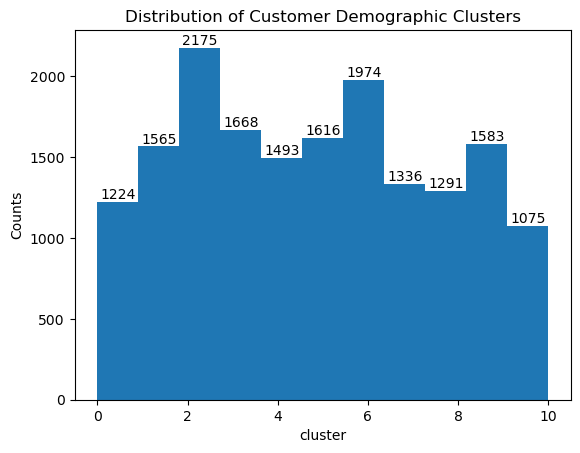

In [36]:
# Now assign the cluster from above to each customer in the profile
profiledf4['cluster'] = profiledf5_cluster_pred

# plot no. of customers by cluster
plot_histogram(profiledf4, "Distribution of Customer Demographic Clusters",
               "cluster", NumClusters)

# Let's see cluster centers in the X_train_pred_clusterdf
X_train_pred_clusterdf

The histogram above shows count of customers clustered almost uniformly; cluster3 having the highest number of customers and cluster11 with lowest number of customers. Let's look at the individual clusters with top 5 features influencing it, using the cluster center dataframe.

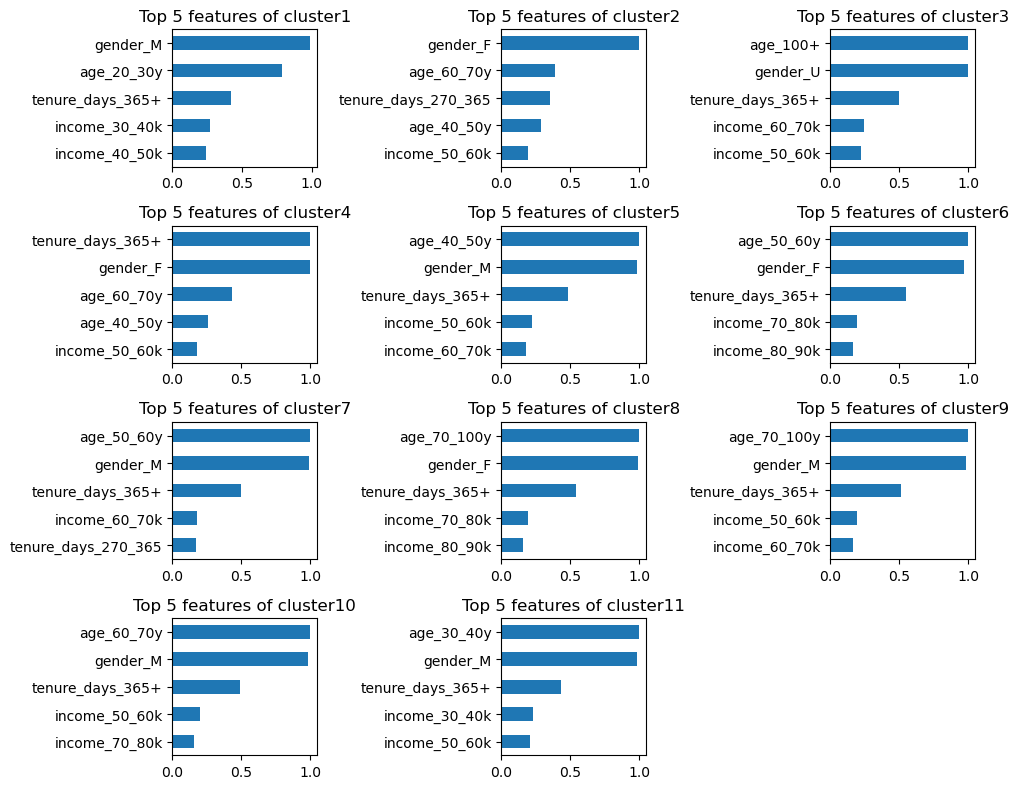

In [37]:
# print individiul clusters with top 5 features influencing it
# below range starts with 1 since our first cluster is named cluster1 as we see above

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 8))

for i, ax in enumerate(axes.flatten()):
    if i + 1 <= NumClusters:
        cluster_name = 'cluster{}'.format(i + 1)
        top_5 = X_train_pred_clusterdf[cluster_name].sort_values(
            ascending=False)[:5]
        top_5.sort_values(ascending=True, inplace=True)
        top_5_df = pd.DataFrame({'index': top_5.index, 'col': top_5.values})
        top_5_df = top_5_df.reset_index(drop=True)
        real_cluster_name = 'cluster{}'.format(i + 1)
        top_5_df.plot(kind='barh',
                      x='index',
                      y='col',
                      legend=False,
                      ax=ax,
                      title='Top 5 features of {}'.format(real_cluster_name))
        ax.set_ylabel('')
    else:
        ax.axis('off')

fig.tight_layout()

The cluster centers represent the average values of each feature for each cluster. From the X_train_pred_clusterdf, we observe below:

- Gender is an important feature for clustering, as cluster1 has a high value for gender_M, cluster2, 4, 6, and cluster8 have high values for gender_F, and cluster3 has a high value for gender_U.

- Age is also an important feature, as cluster1 has a high value for age_20_30y, cluster3, 5 through 11 have high values for age features.

- Cluster8 and 9 seem to indicate female and male **retirement** age groups(70-100y). There could be named as **Women Retirees and Men Retirees** clusters.

- Tenure_days_365+ is an important feature for clustering, we can see it appearing dominantly in 7 out of 11 clusters.

- Gender U and Age 100+ are dominant in **cluster3**, where customers most likely did not supply gender or age. Earlier we observed that this group has high income, which can justify the cluster3 name, **Affluent**.

- Income features are also important for clustering, as different clusters have high values of different income ranges. For example, cluster3 has a high value for feature income_50_60k, cluster5 has high values for income_30_40k, income_40_50k, and income_50_60k, and cluster9 has a high value for income_70_80k.

Overall, the cluster centers suggest that the clustering algorithm has identified distinct groups of customers based on their gender, age, tenure, and income. 

In [38]:
# check once more if any missing values
create_missing_values_table(profiledf4)

# Make a clean version for profile to use in subsequent steps and also save to csv
profileDF_clean = profiledf4.copy()
profileDF_clean.to_csv("profileDF_clean.csv")
info_on_df(profileDF_clean)

Your selected dataframe has 37 columns.
----------------------------------------------------
There are 0 columns that have missing values.
------------------------------------
Shape of DataFrame: (17000, 37)
Columns of DataFrame: Index(['id', 'income_0_20k', 'income_20_30k', 'income_30_40k', 'income_40_50k',
       'income_50_60k', 'income_60_70k', 'income_70_80k', 'income_80_90k',
       'income_90_100k', 'income_100_110k', 'income_110_120k', 'income_120+',
       'tenure_days_0_30', 'tenure_days_30_60', 'tenure_days_60_90',
       'tenure_days_90_120', 'tenure_days_120_150', 'tenure_days_150_180',
       'tenure_days_180_210', 'tenure_days_210_240', 'tenure_days_240_270',
       'tenure_days_270_365', 'tenure_days_365+', 'gender_F', 'gender_M',
       'gender_O', 'gender_U', 'age_0_20y', 'age_20_30y', 'age_30_40y',
       'age_40_50y', 'age_50_60y', 'age_60_70y', 'age_70_100y', 'age_100+',
       'cluster'],
      dtype='object')


# Clustering Model Deployment option: 
Below we will demonstrate a model deployment option by loading the saved clustering model and predicting cluster for a profile data point:

In [39]:
# Let's demonstrate how to deploy the model with a existing data point from the profiledf5

# load model from pkl file
model = joblib.load('modelkmeans.pkl')

print("sample data point:\n", profiledf5.iloc[5421])

# since one data point, need to reshape
xDataPointforKmeans = np.array(profiledf5)[5421, ].reshape(1, -1)
printf(xDataPointforKmeans.shape)

# call the predict method on the model
yPredforKmeans = modelkm.predict(xDataPointforKmeans)

printf("yPredforKmeans shape:", yPredforKmeans.shape)
print("predicted cluster for the given xDataPointforKmeans=", yPredforKmeans)

sample data point:
 income_0_20k           0
income_20_30k          0
income_30_40k          0
income_40_50k          1
income_50_60k          0
income_60_70k          0
income_70_80k          0
income_80_90k          0
income_90_100k         0
income_100_110k        0
income_110_120k        0
income_120+            0
tenure_days_0_30       0
tenure_days_30_60      0
tenure_days_60_90      0
tenure_days_90_120     0
tenure_days_120_150    0
tenure_days_150_180    0
tenure_days_180_210    0
tenure_days_210_240    0
tenure_days_240_270    0
tenure_days_270_365    1
tenure_days_365+       0
gender_F               0
gender_M               1
gender_O               0
gender_U               0
age_0_20y              0
age_20_30y             0
age_30_40y             1
age_40_50y             0
age_50_60y             0
age_60_70y             0
age_70_100y            0
age_100+               0
Name: 5421, dtype: uint8
predicted cluster for the given xDataPointforKmeans= [10]


# ===============================================
# Now let's explore and analyze at the portfolio dataset.

In [40]:
# portfolio structure
print("\n portfolio info:", portfolio.info())
print("\n portfolio summary stats: \n", portfolio.describe())
create_missing_values_table(portfolio)

# portfolio has few records; let's see them
print("\n portfolio records:\n")
portfolio.head(11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes

 portfolio info: None

 portfolio summary stats: 
           reward  difficulty   duration
count  10.000000   10.000000  10.000000
mean    4.200000    7.700000   6.500000
std     3.583915    5.831905   2.321398
min     0.000000    0.000000   3.000000
25%     2.000000    5.000000   5.000000
50%     4.000000    8.500000   7.000000
75%     5.000000   10.000000   7.000000
max    10.000000   20.000000  10.000000
Your selected dataframe has 6 columns.
----------------------------------------------------
There are 0 columns 

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


#### Notice the channel column contains list of channels separated by comma; we need special function to spilt and create dummy columns for those channels.

In [41]:
def create_dummy_channel_variables(df, column_name):
    """
    Create dummy variables for each value in a column that contains lists of values.
    parameter:
        df : The DataFrame containing the column to be transformed.
        column_name : The name of the column that contains LIST of values to be transformed to dummy vars
    Returns:
        DataFrame: A new DataFrame with one column for each unique value in the original column, with dummy variables
        set to 1 if the original column contained that value.
    """
    # create a list of unique values in the column_name
    unique_values = list(
        set([val for sublist in df[column_name] for val in sublist]))

    # create a new column for each unique value and set to 0
    for value in unique_values:
        df[value] = 0

    # set the dummy variable to 1 if the original column contains that value
    for index, row in df.iterrows():
        for value in row[column_name]:
            df.at[index, value] = 1

    # drop the original column
    df = df.drop(column_name, axis=1)

    return df

In [42]:
# Convert duration from days to hours since transcript time is in hours
portfolio.duration *= 24

# call the function above to create dummy var for the channels in portfolio
portfoliodf1 = create_dummy_channel_variables(portfolio, 'channels')

# see the dummy var for the channels in portfolio
portfoliodf1.head()

,reward,difficulty,duration,offer_type,id,mobile,web,email,social
0,10,10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,1,1
1,10,10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,96,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,1,0


In [43]:
# Let's create dummy variable for the offer_type in portfolio
portfoliodf2 = create_dummy_variables(portfoliodf1, 'offer_type', 'OfrTyp')

# let run summary stats on portfolioddf2
portfoliodf2.describe()

,reward,difficulty,duration,mobile,web,email,social,OfrTyp_bogo,OfrTyp_discount,OfrTyp_informational
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000,10.000000
mean,4.200000,7.700000,156.000000,0.900000,0.800000,1.0,0.600000,0.400000,0.400000,0.200000
std,3.583915,5.831905,55.713553,0.316228,0.421637,0.0,0.516398,0.516398,0.516398,0.421637
min,0.000000,0.000000,72.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000
25%,2.000000,5.000000,120.000000,1.000000,1.000000,1.0,0.000000,0.000000,0.000000,0.000000
50%,4.000000,8.500000,168.000000,1.000000,1.000000,1.0,1.000000,0.000000,0.000000,0.000000
75%,5.000000,10.000000,168.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,0.000000
max,10.000000,20.000000,240.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000


In [44]:
# Since the portfoliodf2 looks good, lets make a _clean copy
portfoliodf_clean = portfoliodf2.copy()

# Save the cleaned up data to csv
portfoliodf_clean.to_csv("portfoliodf_clean.csv")

# ================================================
# Now let's look at the third, transcript dataset.

In [45]:
# transcript structure
transcript.info()

# transcript sample data
print(transcript.head())

print("\nSummary stats for the transcript dataset:")
transcript.describe(include='all')

# Let's get missing values report for transcript df
create_missing_values_table(transcript)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB
                             person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2

,DataTypes,Missing Values,% of Total Values


<AxesSubplot: title={'center': 'Transcript Time (hrs) since start for the offer'}>

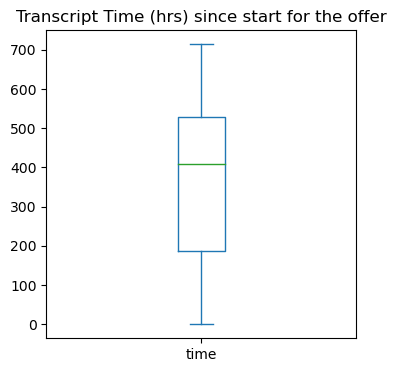

In [46]:
# boxplot for outliers in time variable
transcript["time"].plot.box(
    title="Transcript Time (hrs) since start for the offer", figsize=(4, 4))

#### Based on the boxplot above, we don't see any outliers in the time variable.

In [47]:
# Let's get value counts for event.
print("event Unique Value Counts:\n", transcript["event"].value_counts())

event Unique Value Counts:
 transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64


In [48]:
# split the transcript DF into 4 distinct dataframes based on event types, transaction,
# offer received, offer viewed, offer completed

purchasedf1 = transcript[transcript['event'] == 'transaction']
info_on_df(purchasedf1)

offer_received_df1 = transcript[transcript['event'] == 'offer received']
info_on_df(offer_received_df1)

offer_viewed_df1 = transcript[transcript['event'] == 'offer viewed']
info_on_df(offer_viewed_df1)

offer_completed_df1 = transcript[transcript['event'] == 'offer completed']
info_on_df(offer_completed_df1)

------------------------------------
Shape of DataFrame: (138953, 4)
Columns of DataFrame: Index(['person', 'event', 'value', 'time'], dtype='object')
------------------------------------
Shape of DataFrame: (76277, 4)
Columns of DataFrame: Index(['person', 'event', 'value', 'time'], dtype='object')
------------------------------------
Shape of DataFrame: (57725, 4)
Columns of DataFrame: Index(['person', 'event', 'value', 'time'], dtype='object')
------------------------------------
Shape of DataFrame: (33579, 4)
Columns of DataFrame: Index(['person', 'event', 'value', 'time'], dtype='object')


## Let's work on purchase event dataframe:

In [49]:
# reset index on purchase1 and # drop the event column since we already know what each df is
purchasedf2 = purchasedf1.reset_index(drop=True)
purchasedf2.drop(["event"], axis=1, inplace=True)

# Let's see if there are any missing values in purchasedf2
create_missing_values_table(purchasedf2)

Your selected dataframe has 3 columns.
----------------------------------------------------
There are 0 columns that have missing values.


,DataTypes,Missing Values,% of Total Values


In [50]:
def expand_dict_column(df, column_name):
    """
    Utility function expands a column of dictionaries in a DataFrame to multiple columns in the same DataFrame.
    Args:
    - df: DataFrame containing the column to be expanded
    - column_name: the name of the column to be expanded
    Returns:
    - A DataFrame with the expanded columns from the dictionary.
    """
    printf("\n----In function expand_dict_column------\n")
    df.reset_index(inplace=True, drop=True)
    printf("Before df shape=", df.shape)

    # convert the column of dictionaries to a DataFrame
    # df_expanded = df.from_records(df[column_name]) also works; revisit later
    df_expanded = pd.json_normalize(df[column_name])
    df_expanded.reset_index(inplace=True, drop=True)
    printf("df_expanded shape=", df_expanded.shape)

    # concatenate the expanded DataFrame with the original DataFrame
    df = pd.concat([df, df_expanded], axis=1)
    printf("After df shape=", df.shape)

    # check if any columns have the same name as the expanded columns and rename them
    expanded_columns = df_expanded.columns
    for col in expanded_columns:
        if col in df.columns and col != column_name:
            df = df.rename(columns={col: f"{column_name}_{col}"})

    # drop the original column
    df = df.drop(column_name, axis=1)
    printf("\n----Exiting function expand_dict_column------\n")
    return df

In [51]:
# expand the value dict column to multiple columns using function above
PRINT = True
purchasedf3 = expand_dict_column(purchasedf2, 'value')
info_on_df(purchasedf3)

# rename value_amount to purchase_amount
purchasedf3.rename(columns={'value_amount': 'purchase_amount'}, inplace=True)

print(purchasedf3.info())


----In function expand_dict_column------

Before df shape= (138953, 3)
df_expanded shape= (138953, 1)
After df shape= (138953, 4)

----Exiting function expand_dict_column------

------------------------------------
Shape of DataFrame: (138953, 3)
Columns of DataFrame: Index(['person', 'time', 'value_amount'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138953 entries, 0 to 138952
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   person           138953 non-null  object 
 1   time             138953 non-null  int64  
 2   purchase_amount  138953 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB
None


In [52]:
# let's get a reportin on missing values on purchasedf2
create_missing_values_table(purchasedf3)

# Get the total purchase amount before removing rows with missing values
print("purchasedf3 Total purchase amount = ",
      round(purchasedf3["purchase_amount"].sum(), 2))

# let's get summary stats
purchasedf3.describe(include='all')

Your selected dataframe has 3 columns.
----------------------------------------------------
There are 0 columns that have missing values.
purchasedf3 Total purchase amount =  1775451.97


,person,time,purchase_amount
count,138953,138953.000000,138953.000000
unique,16578,NaN,NaN
top,79d9d4f86aca4bed9290350fb43817c2,NaN,NaN
freq,36,NaN,NaN
mean,NaN,381.584334,12.777356
std,NaN,201.697230,30.250529
min,NaN,0.000000,0.050000
25%,NaN,210.000000,2.780000
50%,NaN,402.000000,8.890000
75%,NaN,552.000000,18.070000


#### We see above purchase_amount range from 0 to 1062, there are definitely some outliers since who purchases \$1062 worth of coffee? 

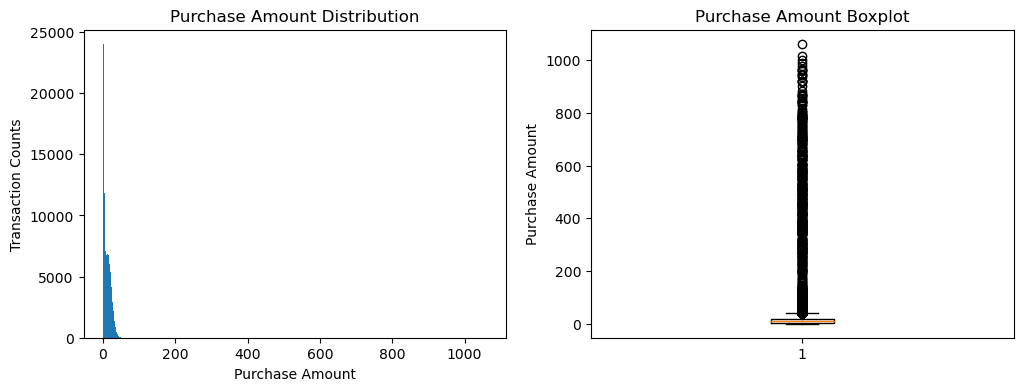

In [53]:
# let's see the purchase_amount distribution via histogram and outliers via boxplot
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))

# purchase_amount - Histogram
ax1.hist(purchasedf3["purchase_amount"], bins=600)
ax1.set_title('Purchase Amount Distribution')
ax1.set_xlabel('Purchase Amount')
ax1.set_ylabel('Transaction Counts')

# purchase_amount - Boxplot
ax2.boxplot(purchasedf3["purchase_amount"])
ax2.set_title('Purchase Amount Boxplot')
ax2.set_ylabel('Purchase Amount')

plt.show()

 #### Outliers in purchase_amount warrants special mention since obviously there are outliers. We have 3 options:
###### 1) Remove the outliers in purchase_amount in first dataframe.
 purchasedf_clean = remove_outliers(purchasedf3, "purchase_amount")
###### 2) Remove records with huge purchase amounts, using high range limit.
 purchasedf_clean = purchasedf3[purchasedf3["purchase_amount"] <= purchase_high_limit]
###### 3)  Remove outliers from subsequent dataframes when we split the purchases as qualified, unqualified and purchase-w/o-offer into separate dataframes

#### We will go with the third option, to remove outliers from subsequent dataframes when we split the purchase dataset.

In [54]:
# let's round the purchase_amount; copy is needed to avoid warning
purchasedf_clean = purchasedf3.copy()  ## leaving all outlier data with this

purchasedf_clean['purchase_amount'] = purchasedf_clean[
    'purchase_amount'].round(2)

# purchasedf_clean["purchase_amount"].describe()

# Get the total purchase amount
print("purchasedf_clean Total purchase amount = ",
      round(purchasedf_clean["purchase_amount"].sum(), 2))

purchasedf_clean Total purchase amount =  1775451.97


<AxesSubplot: title={'center': 'purchasedf_clean time Boxplot'}>

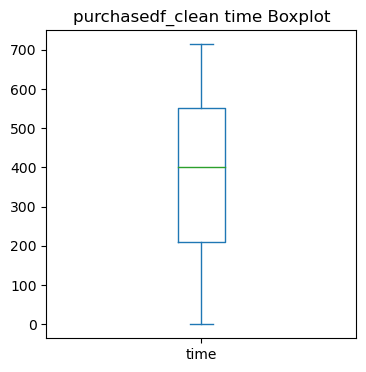

In [55]:
# Let's see how time variable looks, if there are any outliers
purchasedf_clean["time"].plot.box(figsize=(4, 4),
                                  title="purchasedf_clean time Boxplot")

#### The time variable looks good, no obvious outliers.

In [56]:
# verify there are no missing values in purchasedf_clean
create_missing_values_table(purchasedf_clean)

# save purchasedf_clean to csv
purchasedf_clean.to_csv("purchasedf_clean.csv")

Your selected dataframe has 3 columns.
----------------------------------------------------
There are 0 columns that have missing values.


### So purchasedf_clean dataframe is in good shape to use for subsequent modeling/analysis.
## =====================================================================
# Let's work on cleaning up the split offers datasets. 

Since offer_received_df1, offer_viewed_df1, and offer_completed_df1 have identical structure, created a function to reduce duplication. This was an afterthought hence the function looks bulky!

In [57]:
def clean_offer_dataframe(offerdf1, portfoliodf1, portfoliodf_clean,
                          offerevent):
    """
    This function takes an offer dataframe as input and performs the following processing:
    1. Remove the 'event' column and reset the index.
    2. Check for missing values in the dataframe.
    3. Expand the 'value' dictionary column to multiple columns.
    4. Remove spaces in the 'value_offer id' column by renaming it.
    5. Merge the dataframe with the portfolio dataframe on offer ids to get offer details.
    6. Group the data and calculate the counts.
    7. Calculate the percentages and labels.
    8. Create a pie chart of customer proportions and counts by offer types received.
    9. Copy the resulting cleaned dataframe to a new dataframe and return it.
    Parameters:
    df : the input offer dataframe.
    portfoliodf1 : portfoliodf1 dataframe with offer_type
    portfoliodf_clean : portfoliodf_clean without offer_type
    offerevent : string either received, viewed, or completed
    Returns:
    DataFrame: the cleaned offer dataframe.
    """

    # Create offer_df2, without the event column and reset the index
    offerdf2 = offerdf1[['person', 'time', 'value']]
    offerdf2.reset_index(inplace=True, drop=True)
    info_on_df(offerdf2)

    # Let's see if there are any missing values in offerdf2
    create_missing_values_table(offerdf2)

    # expand the value dict column to multiple column using function above
    offerdf3 = expand_dict_column(offerdf2, 'value')

    offerdf3.reset_index(inplace=True, drop=True)
    offerdf3.info()

    # The value dictionary expansion went well; remove space in the "value_offer id" by rename
    offerdf3.rename(columns={"value_offer id": 'value_offer_id'}, inplace=True)
    info_on_df(offerdf3)

    # let's get a report on missing values on offerdf3
    create_missing_values_table(offerdf3)

    # Show how many persons recieved what type of offer
    # let's merge offerdf3 with portfoliodf1 (specifically) on offer ids to get offer type for plot
    offerdf3a = offerdf3.merge(portfoliodf1,
                               how='left',
                               left_on=["value_offer_id"],
                               right_on=["id"])

    # drop the id column from offerdf4
    offerdf3a.drop(["id"], axis=1, inplace=True)
    # info_on_df(offerdf3a)

    # group the data and calculate the counts
    count_by_offer = offerdf3a.groupby('offer_type')['person'].nunique()
    total_count = count_by_offer.sum()

    # calculate the percentages and labels
    labels = [
        f"{label}: {count}"
        for label, count in zip(count_by_offer.index, count_by_offer)
    ]

    # create the pie chart
    plt.pie(count_by_offer, labels=labels, autopct='%1.1f%%')
    plt.title(f'Unique Customer Counts & Proportions by {offerevent} Offer Types')
    plt.show()

    # let's merge offerdf3 with portfolio_clean on offer ids to get offer details
    offerdf4 = offerdf3.merge(portfoliodf_clean,
                              how='left',
                              left_on=["value_offer_id"],
                              right_on=["id"])

    # drop the id column from offerdf4
    offerdf4.drop(["id"], axis=1, inplace=True)

    info_on_df(offerdf4)

    # let's get a report on missing values on offerdf4
    create_missing_values_table(offerdf4)

    # now that offerdf3 looks good, let's copy it to _clean
    offerdf_clean = offerdf4.copy()

    # how many unique persons in offerdf_clean
    print(f"Count of unique persons in {offerevent} offerdf_clean:",
          offerdf_clean['person'].unique().shape)

    return offerdf_clean

------------------------------------
Shape of DataFrame: (76277, 3)
Columns of DataFrame: Index(['person', 'time', 'value'], dtype='object')
Your selected dataframe has 3 columns.
----------------------------------------------------
There are 0 columns that have missing values.

----In function expand_dict_column------

Before df shape= (76277, 3)
df_expanded shape= (76277, 1)
After df shape= (76277, 4)

----Exiting function expand_dict_column------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76277 entries, 0 to 76276
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   person          76277 non-null  object
 1   time            76277 non-null  int64 
 2   value_offer id  76277 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
------------------------------------
Shape of DataFrame: (76277, 3)
Columns of DataFrame: Index(['person', 'time', 'value_offer_id'], dtype='object')
Your selected dat

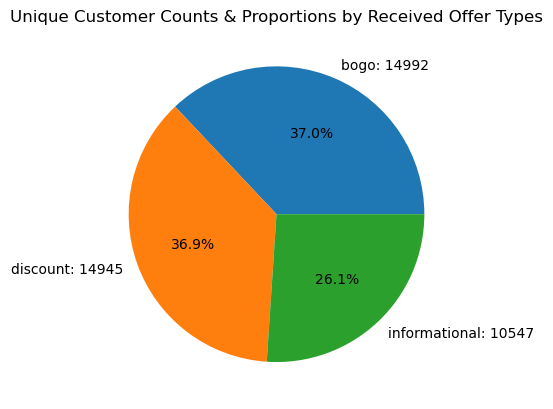

------------------------------------
Shape of DataFrame: (76277, 13)
Columns of DataFrame: Index(['person', 'time', 'value_offer_id', 'reward', 'difficulty', 'duration',
       'mobile', 'web', 'email', 'social', 'OfrTyp_bogo', 'OfrTyp_discount',
       'OfrTyp_informational'],
      dtype='object')
Your selected dataframe has 13 columns.
----------------------------------------------------
There are 0 columns that have missing values.
Count of unique persons in Received offerdf_clean: (16994,)


In [58]:
# Process offer_received_df1 using function above
offer_receiveddf_clean = clean_offer_dataframe(offer_received_df1,
                                               portfoliodf1, portfoliodf_clean,
                                               'Received')

------------------------------------
Shape of DataFrame: (57725, 3)
Columns of DataFrame: Index(['person', 'time', 'value'], dtype='object')
Your selected dataframe has 3 columns.
----------------------------------------------------
There are 0 columns that have missing values.

----In function expand_dict_column------

Before df shape= (57725, 3)
df_expanded shape= (57725, 1)
After df shape= (57725, 4)

----Exiting function expand_dict_column------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57725 entries, 0 to 57724
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   person          57725 non-null  object
 1   time            57725 non-null  int64 
 2   value_offer id  57725 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB
------------------------------------
Shape of DataFrame: (57725, 3)
Columns of DataFrame: Index(['person', 'time', 'value_offer_id'], dtype='object')
Your selected dat

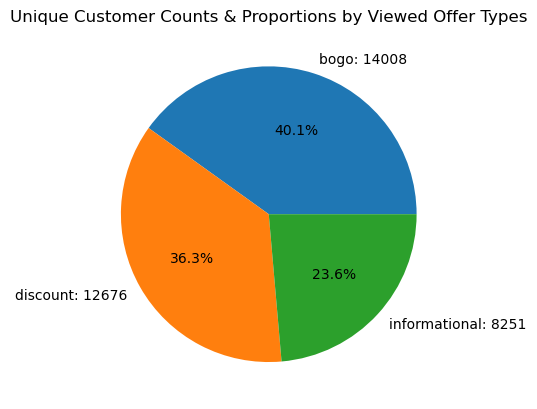

------------------------------------
Shape of DataFrame: (57725, 13)
Columns of DataFrame: Index(['person', 'time', 'value_offer_id', 'reward', 'difficulty', 'duration',
       'mobile', 'web', 'email', 'social', 'OfrTyp_bogo', 'OfrTyp_discount',
       'OfrTyp_informational'],
      dtype='object')
Your selected dataframe has 13 columns.
----------------------------------------------------
There are 0 columns that have missing values.
Count of unique persons in Viewed offerdf_clean: (16834,)


In [59]:
# Process offer_viewed_df1 using function above
offer_vieweddf_clean = clean_offer_dataframe(offer_viewed_df1, portfoliodf1,
                                             portfoliodf_clean, 'Viewed')

------------------------------------
Shape of DataFrame: (33579, 3)
Columns of DataFrame: Index(['person', 'time', 'value'], dtype='object')
Your selected dataframe has 3 columns.
----------------------------------------------------
There are 0 columns that have missing values.

----In function expand_dict_column------

Before df shape= (33579, 3)
df_expanded shape= (33579, 2)
After df shape= (33579, 5)

----Exiting function expand_dict_column------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33579 entries, 0 to 33578
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   person          33579 non-null  object
 1   time            33579 non-null  int64 
 2   value_offer_id  33579 non-null  object
 3   value_reward    33579 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.0+ MB
------------------------------------
Shape of DataFrame: (33579, 4)
Columns of DataFrame: Index(['person', 'time', 'value_o

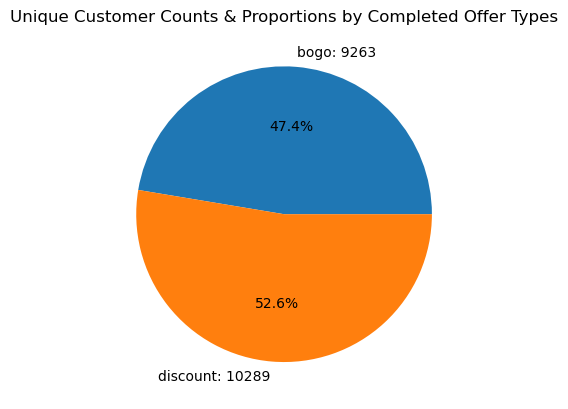

------------------------------------
Shape of DataFrame: (33579, 14)
Columns of DataFrame: Index(['person', 'time', 'value_offer_id', 'value_reward', 'reward',
       'difficulty', 'duration', 'mobile', 'web', 'email', 'social',
       'OfrTyp_bogo', 'OfrTyp_discount', 'OfrTyp_informational'],
      dtype='object')
Your selected dataframe has 14 columns.
----------------------------------------------------
There are 0 columns that have missing values.
Count of unique persons in Completed offerdf_clean: (12774,)


In [60]:
# Process offer_completed_df1 using function above
offer_completeddf_clean = clean_offer_dataframe(offer_completed_df1,
                                                portfoliodf1,
                                                portfoliodf_clean, 'Completed')

### Merging the dataframes offer_receiveddf_clean, offer_vieweddf_clean, and offer_completeddf_clean : ===============
select distinct c.* , case when vw.difficulty is not null then 1 else 0 end as offer_viewed,
case when cmp.difficulty is not null then 1 else 0 end as offer_completed,
from offer_receiveddf_clean rcv
left join offer_vieweddf_clean vw
on (rcv.person = vw.person
and rcv.time <= vw.time
and rcv.value_offer_id = vw.value_offer_id
)
left join offer_completeddf_clean cmp
on (rcv.person = cmp.person
and rcv.time <= cmp.time
and rcv.value_offer_id = cmp.value_offer_id) 

below is equivalent code >>>>>

In [61]:
## Begin merging the dataframes offer_receiveddf_clean, offer_vieweddf_clean, and offer_completeddf_clean
info_on_df(offer_receiveddf_clean)
info_on_df(offer_vieweddf_clean)
info_on_df(offer_completeddf_clean)

# make a copy of the offer_receiveddf_clean to add offer_received column with default value of 1
ofr_rcv_cln_tmp = offer_receiveddf_clean.copy()
ofr_rcv_cln_tmp['offer_received'] =1

# first merge the dataframes ofr_rcv_cln_tmp, offer_vieweddf_clean
merged_df = offer_receiveddf_clean.merge(ofr_rcv_cln_tmp,
                                         on=['person', 'value_offer_id'],
                                         how='left',
                                         suffixes=['', '_viewed'])
merged_df.reset_index(drop=True, inplace=True)

# now merge the dataframes merged_df and offer_completeddf_clean
merged_df = merged_df.merge(offer_completeddf_clean,
                            on=['person', 'value_offer_id'],
                            how='left',
                            suffixes=['', '_completed'])
merged_df.reset_index(drop=True, inplace=True)

# set the offer_viewed and offer_completed indicators
merged_df['offer_viewed'] = np.where(
    (merged_df['time_viewed'].notnull()) &
    (merged_df['time_viewed'] >= merged_df['time']), 1, 0)
merged_df['offer_completed'] = np.where(
    (merged_df['time_completed'].notnull()) &
    (merged_df['time_completed'] >= merged_df['time']), 1, 0)

# create new final_offers_df with only needed columns
final_offers_df = merged_df[[
    'person', 'time', 'duration', 'offer_received', 'offer_viewed',
    'offer_completed','OfrTyp_bogo', 'OfrTyp_discount', 'OfrTyp_informational','value_offer_id',
    'value_reward', 'reward', 'difficulty',
    'web', 'social', 'email', 'mobile']].drop_duplicates(keep='first')

# SQL-type groupby to aggregate by person, time, and value offer id; this will keep the record count same as offer_received
final_offers_df = final_offers_df.groupby(by=['person', 'time', 'value_offer_id'],as_index=False).max()

info_on_df(final_offers_df)
# let's get a report on missing values on offerdf4
create_missing_values_table(final_offers_df)

# fill missing values in value_reward with 0 since that's what it is if missing.
final_offers_df.fillna(value={"value_reward": 0}, inplace=True)
final_offers_df.reset_index(inplace=True, drop=True)

# Call create_missing_values_table function with final_offers_df
create_missing_values_table(final_offers_df)

final_offers_df.info()

# print sample record final_offers_df.iloc[6987]
## End merging the dataframes offer_receiveddf_clean, offer_vieweddf_clean, and offer_completeddf_clean

------------------------------------
Shape of DataFrame: (76277, 13)
Columns of DataFrame: Index(['person', 'time', 'value_offer_id', 'reward', 'difficulty', 'duration',
       'mobile', 'web', 'email', 'social', 'OfrTyp_bogo', 'OfrTyp_discount',
       'OfrTyp_informational'],
      dtype='object')
------------------------------------
Shape of DataFrame: (57725, 13)
Columns of DataFrame: Index(['person', 'time', 'value_offer_id', 'reward', 'difficulty', 'duration',
       'mobile', 'web', 'email', 'social', 'OfrTyp_bogo', 'OfrTyp_discount',
       'OfrTyp_informational'],
      dtype='object')
------------------------------------
Shape of DataFrame: (33579, 14)
Columns of DataFrame: Index(['person', 'time', 'value_offer_id', 'value_reward', 'reward',
       'difficulty', 'duration', 'mobile', 'web', 'email', 'social',
       'OfrTyp_bogo', 'OfrTyp_discount', 'OfrTyp_informational'],
      dtype='object')
------------------------------------
Shape of DataFrame: (76277, 17)
Columns of D

### Even though we have merged dataframes offer_receiveddf_clean, offer_vieweddf_clean, and offer_completeddf_clean, we will only use the offer_receiveddf_clean for modeling to determine purchase as qualified because the offer duration begins from the offer receipt.

### We now have cleaned purchase data (purchasedf_clean) and offer received (offer_receiveddf_clean), we can tag the purchases as qualified, unqualified or without-offer. There are 5 groups of customers, we can think of:

- Customers who received offers and purchased within the offer duration >> **qualified purchases**, this is our target demographics.
- Customers who received offers and purchased outside the offer duration >> **unqualified purchases**, should we send offers to these customers, yes!
- Customers who did NOT receive any offers and purchased anyways >> **without offer purchases**, we may send offers to these customers, to encourage more purchase
- Customers who received offers and did NOT purchase at all >> **offers given no purchases**, should we send offers to these customers, yes!
- Customers who did NOT receive offers and did NOT purchase >> **no Offers no purchases** we need not send offers to these customers.

In [62]:
# Start splitting the purchases; first make fresh copies to work with
OfferDF = offer_receiveddf_clean
purchaseDF = purchasedf_clean

OfferDF.reset_index(inplace=True, drop=True)
purchaseDF.reset_index(inplace=True, drop=True)

print("\n purchaseDF Total purchase amount = ",
      round(purchaseDF["purchase_amount"].sum(), 2))


 purchaseDF Total purchase amount =  1775451.97


In [63]:
# Create qualified offers dataframe, for purchases within the offer duration window
qual_ofr_tmp = OfferDF.merge(purchaseDF,
                                 on=['person'],
                                 suffixes=('_offer', '_purchase'))
# printf(qualified_offers.head())

# qualified_offers.info()
qual_ofr_tmp2 = qual_ofr_tmp[(qual_ofr_tmp['time_purchase'].between(
    qual_ofr_tmp['time_offer'],
    (qual_ofr_tmp['time_offer'] + qual_ofr_tmp['duration'])))]

qualified_offers = qual_ofr_tmp2.drop(['time_offer'], axis=1)
qualified_offers.rename(columns={'time_purchase': 'time'}, inplace=True)

qualified_offers.drop_duplicates(keep='first', inplace=True)
qualified_offers.reset_index(inplace=True, drop=True)

# Create new varaible purchase type for qualified purchases
qualified_offers['purchase_type'] = 'qualified'

# 3/30 change below : SQL type group by to aggregate by person, time, and value offer id; this will keep the record count same as offer received
qualified_offers = qualified_offers.groupby(by=['person', 'time'],as_index=False).max()

print("qualified_offers=\n", qualified_offers.info())

print("\n qualified_offers Total purchase amount   = ",
      qualified_offers["purchase_amount"].sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121863 entries, 0 to 121862
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   person                121863 non-null  object 
 1   time                  121863 non-null  int64  
 2   value_offer_id        121863 non-null  object 
 3   reward                121863 non-null  int64  
 4   difficulty            121863 non-null  int64  
 5   duration              121863 non-null  int64  
 6   mobile                121863 non-null  int64  
 7   web                   121863 non-null  int64  
 8   email                 121863 non-null  int64  
 9   social                121863 non-null  int64  
 10  OfrTyp_bogo           121863 non-null  uint8  
 11  OfrTyp_discount       121863 non-null  uint8  
 12  OfrTyp_informational  121863 non-null  uint8  
 13  purchase_amount       121863 non-null  float64
 14  purchase_type         121863 non-null  object 
dtype

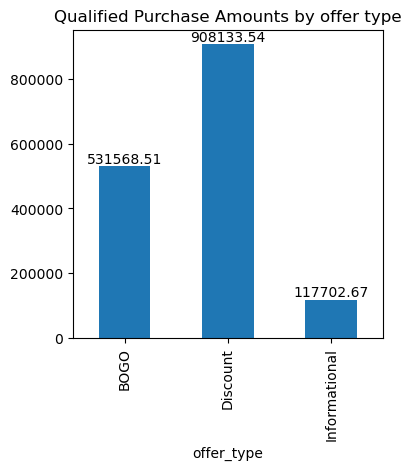

In [64]:
# Analyze purchase amount by offer type
QDF = qualified_offers.copy()
QDF['offer_type'] = np.where(
    QDF['OfrTyp_discount'] == 1, 'Discount',
    np.where(QDF['OfrTyp_bogo'] == 1, 'BOGO', 'Informational'))
QDF = QDF.groupby('offer_type')['purchase_amount'].sum()

# Plot the purchase amounts by offer type
ax = QDF.plot(kind='bar',
              figsize=(4, 4),
              title='Qualified Purchase Amounts by offer type')
for i, v in enumerate(QDF.values):
    ax.annotate(str(v), xy=(i, v), ha='center', va='bottom')
plt.show()

In [65]:
# Find purchases without receiving any offers
# Get the list of persons that received the offer
persons_to_exclude = OfferDF['person'].unique()

# Filter the purchase records where person is not in the above list
purchaseWOOffer = purchaseDF[~purchaseDF["person"].isin(persons_to_exclude)]

print("\n Purchase w/o offer, total purchase amount   = ",
      purchaseWOOffer["purchase_amount"].sum())

purchaseWOOffer.info()


 Purchase w/o offer, total purchase amount   =  250.61
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 894 to 127874
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   person           20 non-null     object 
 1   time             20 non-null     int64  
 2   purchase_amount  20 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 640.0+ bytes


In [66]:
# let's create purchaseDFQual for identifying unqualified purchases
purchaseDFQual = qualified_offers[['person', 'time', 'purchase_amount']]
purchaseDFQual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121863 entries, 0 to 121862
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   person           121863 non-null  object 
 1   time             121863 non-null  int64  
 2   purchase_amount  121863 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.8+ MB


In [67]:
# combine purchaseDFQual and purchaseWOOffer into one dataframe
purchaseDFQualWOOffer = pd.concat([purchaseWOOffer, purchaseDFQual], axis=0)

info_on_df(purchaseDFQualWOOffer)

------------------------------------
Shape of DataFrame: (121883, 3)
Columns of DataFrame: Index(['person', 'time', 'purchase_amount'], dtype='object')


#### Now we need to remove purchaseDFQualWOOffer rows from the purchaseDF, which will give the unqualified_purchase_DF.

In [68]:
# Merge the purchasedf and qualpurch dataframes
merged = purchaseDF.merge(purchaseDFQualWOOffer,
                          on=['person', 'time', 'purchase_amount'],
                          how='outer',
                          indicator=True)

# Select the rows that are only in the purchasedf dataframe
unqualified_purchase_DF = merged[merged['_merge'] == 'left_only'][[
    'person', 'time', 'purchase_amount'
]]

# print(unqualified_purchase_DF)
print("\nUnqualified_purchase_DF, total purchase amount   = ",
      unqualified_purchase_DF["purchase_amount"].sum())


Unqualified_purchase_DF, total purchase amount   =  217796.64


In [69]:
# validate the splits of purchases amounts equate to the starting total purchase amount:
purchaseDF_total_purchase = round(purchaseDF["purchase_amount"].sum(), 2)

# sum of purchases from the splits
sum_of_splits_total_purchase = round(
    qualified_offers["purchase_amount"].sum() +
    purchaseWOOffer["purchase_amount"].sum() +
    unqualified_purchase_DF["purchase_amount"].sum(), 2)

# compare and print the total purchase amounts
print("purchaseDF_total_purchase=", purchaseDF_total_purchase,
      ", sum_of_splits_total_purchase=", sum_of_splits_total_purchase,
      " >> Matched = ",
      purchaseDF_total_purchase == sum_of_splits_total_purchase)

purchaseDF_total_purchase= 1775451.97 , sum_of_splits_total_purchase= 1775451.97  >> Matched =  True


#### Let's find out Customers received offers and did NOT purchase at all

In [70]:
# receiving offers but did not make any purchases
# First get a list of persons that made any purchase anytime
persons_to_exclude = purchaseDF['person'].unique()

# Filter the offer records where person is not in the above list
OfferWOPurchaseDF = OfferDF[~OfferDF["person"].isin(persons_to_exclude)]

OfferWOPurchaseDF.info()

print("No of persons who received offers but did not make any purchases=",
      OfferWOPurchaseDF['person'].unique().shape[0])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1881 entries, 3 to 76180
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   person                1881 non-null   object
 1   time                  1881 non-null   int64 
 2   value_offer_id        1881 non-null   object
 3   reward                1881 non-null   int64 
 4   difficulty            1881 non-null   int64 
 5   duration              1881 non-null   int64 
 6   mobile                1881 non-null   int64 
 7   web                   1881 non-null   int64 
 8   email                 1881 non-null   int64 
 9   social                1881 non-null   int64 
 10  OfrTyp_bogo           1881 non-null   uint8 
 11  OfrTyp_discount       1881 non-null   uint8 
 12  OfrTyp_informational  1881 non-null   uint8 
dtypes: int64(8), object(2), uint8(3)
memory usage: 167.2+ KB
No of persons who received offers but did not make any purchases= 422


#### Find customers in Profile dataset that did NOT receive offers and did NOT purchase:

In [71]:
# Customers who did NOT receive offers and did NOT purchase
# First get a list of persons in profileDF
persons_to_exclude = profileDF_clean['id'].unique()
print("\n Unique no of persons in profile DF:", persons_to_exclude.shape[0])

# Filter the offer records where person is not in the profile list
custInProfileNotInOfferDF = OfferDF[~OfferDF["person"].isin(persons_to_exclude
                                                            )]

info_on_df(custInProfileNotInOfferDF)

print("No of persons in profile but not receiving offers =",
      custInProfileNotInOfferDF['person'].unique().shape[0])

# Filter the purchase records where person is not in the profile list
custInProfileNotInPurchaseDF = purchaseDF[~purchaseDF["person"].
                                          isin(persons_to_exclude)]

info_on_df(custInProfileNotInPurchaseDF)

print(
    "No of persons in profile but not in purchase dataset (not making any purchases)=",
    custInProfileNotInPurchaseDF['person'].unique().shape[0])


 Unique no of persons in profile DF: 17000
------------------------------------
Shape of DataFrame: (0, 13)
Columns of DataFrame: Index(['person', 'time', 'value_offer_id', 'reward', 'difficulty', 'duration',
       'mobile', 'web', 'email', 'social', 'OfrTyp_bogo', 'OfrTyp_discount',
       'OfrTyp_informational'],
      dtype='object')
No of persons in profile but not receiving offers = 0
------------------------------------
Shape of DataFrame: (0, 3)
Columns of DataFrame: Index(['person', 'time', 'purchase_amount'], dtype='object')
No of persons in profile but not in purchase dataset (not making any purchases)= 0



Before removing outliers from qualified_offers:
count    121863.000000
mean         12.779964
std          30.669669
min           0.050000
25%           2.760000
50%           8.800000
75%          18.020000
max        1062.280000
Name: purchase_amount, dtype: float64

---In function remove_outliers ---

------------------------------------
Shape of DataFrame: (121863, 15)
Columns of DataFrame: Index(['person', 'time', 'value_offer_id', 'reward', 'difficulty', 'duration',
       'mobile', 'web', 'email', 'social', 'OfrTyp_bogo', 'OfrTyp_discount',
       'OfrTyp_informational', 'purchase_amount', 'purchase_type'],
      dtype='object')
------------------------------------
Shape of DataFrame: (120786, 15)
Columns of DataFrame: Index(['person', 'time', 'value_offer_id', 'reward', 'difficulty', 'duration',
       'mobile', 'web', 'email', 'social', 'OfrTyp_bogo', 'OfrTyp_discount',
       'OfrTyp_informational', 'purchase_amount', 'purchase_type'],
      dtype='object')

---Leaving func

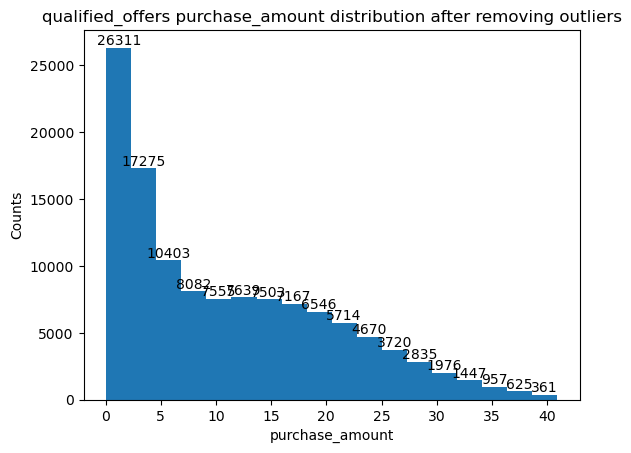


Before removing outliers from purchaseWOOffer:
count    20.000000
mean     12.530500
std       9.577654
min       0.350000
25%       4.340000
50%      10.625000
75%      18.985000
max      28.700000
Name: purchase_amount, dtype: float64

---In function remove_outliers ---

------------------------------------
Shape of DataFrame: (20, 3)
Columns of DataFrame: Index(['person', 'time', 'purchase_amount'], dtype='object')
------------------------------------
Shape of DataFrame: (20, 3)
Columns of DataFrame: Index(['person', 'time', 'purchase_amount'], dtype='object')

---Leaving function remove_outliers ---


After removing outliers from purchaseWOOffer:
count    20.000000
mean     12.530500
std       9.577654
min       0.350000
25%       4.340000
50%      10.625000
75%      18.985000
max      28.700000
Name: purchase_amount, dtype: float64

Total purchase amount in purchaseWOOffer after removing outliers: 250.61


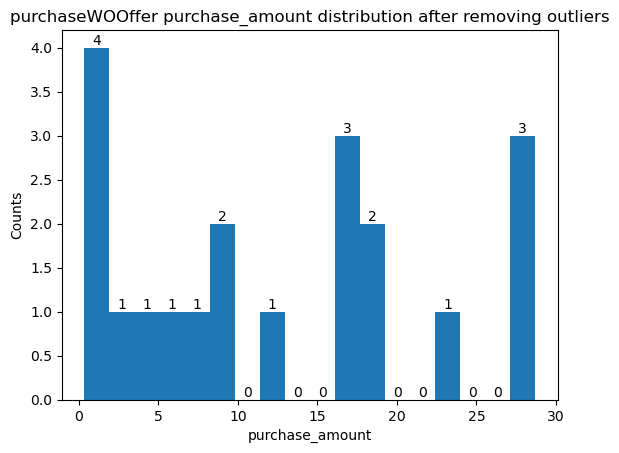


Before removing outliers from unqualified_purchase_DF:
count    17070.000000
mean        12.759030
std         27.089113
min          0.050000
25%          2.900000
50%          9.710000
75%         18.350000
max        962.100000
Name: purchase_amount, dtype: float64

---In function remove_outliers ---

------------------------------------
Shape of DataFrame: (17070, 3)
Columns of DataFrame: Index(['person', 'time', 'purchase_amount'], dtype='object')
------------------------------------
Shape of DataFrame: (16920, 3)
Columns of DataFrame: Index(['person', 'time', 'purchase_amount'], dtype='object')

---Leaving function remove_outliers ---


After removing outliers from unqualified_purchase_DF:
count    16920.000000
mean        11.372433
std          9.435059
min          0.050000
25%          2.880000
50%          9.520000
75%         18.102500
max         41.480000
Name: purchase_amount, dtype: float64

Total purchase amount in unqualified_purchase_DF after removing outliers: 19242

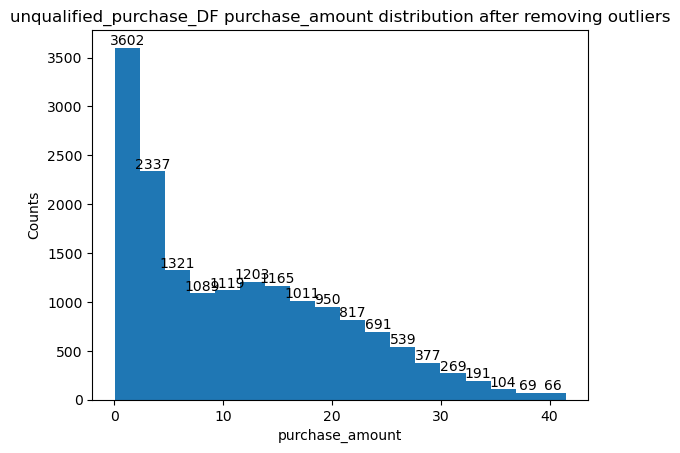

In [72]:
# First TEST/evaludate removing outliers from each of the three DFs qualified_offers, purchaseWOOffer, unqualified_purchase_DF

# Store DFs in a list
dfs = [qualified_offers, purchaseWOOffer, unqualified_purchase_DF]

# repeat for each DF
for i, df in enumerate(dfs):
    df_name = [
        'qualified_offers', 'purchaseWOOffer', 'unqualified_purchase_DF'
    ][i]
    print(f"\nBefore removing outliers from {df_name}:")
    print(df["purchase_amount"].describe())

    # call the the function to remove outliers
    df_wo_outliers = remove_outliers(df, "purchase_amount")

    print(f"\nAfter removing outliers from {df_name}:")
    print(df_wo_outliers["purchase_amount"].describe())

    print(
        f"\nTotal purchase amount in {df_name} after removing outliers: {df_wo_outliers['purchase_amount'].sum()}"
    )

    # call the the function to plot histogram
    plot_histogram(
        df_wo_outliers,
        f"{df_name} purchase_amount distribution after removing outliers",
        'purchase_amount', 18)
    plt.show()

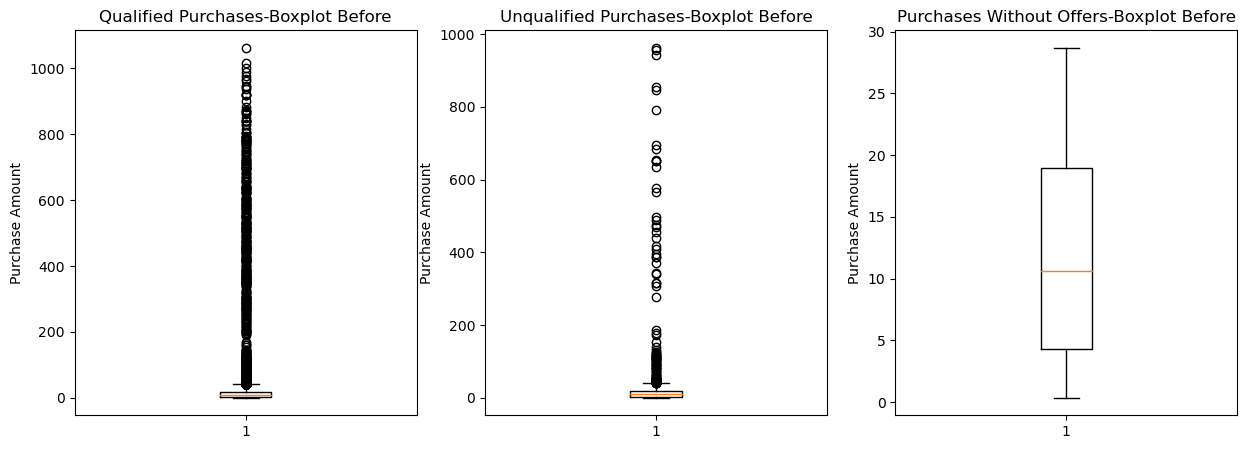

In [73]:
# Boxplot before removing outliers for qualified_offers, purchaseWOOffer, and unqualified_purchase_DF
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))

# qualified_offers - Histogram
ax1.boxplot(qualified_offers["purchase_amount"])
ax1.set_title("Qualified Purchases-Boxplot Before")
ax1.set_ylabel('Purchase Amount')

# unqualified_purchase_DF - Boxplot
ax2.boxplot(unqualified_purchase_DF["purchase_amount"])
ax2.set_title("Unqualified Purchases-Boxplot Before")
ax2.set_ylabel('Purchase Amount')

# purchaseWOOffer - Boxplot
ax3.boxplot(purchaseWOOffer["purchase_amount"])
ax3.set_title('Purchases Without Offers-Boxplot Before')
ax3.set_ylabel('Purchase Amount')

plt.show()

In [74]:
# As we see above, there are outliers in qualified and and unqualified purchase datasets.
# Earlier histograms and outlier-removing-test looks good so let's remove the outliers from the three DFs
qualified_offers = remove_outliers(qualified_offers, "purchase_amount")
purchaseWOOffer = remove_outliers(purchaseWOOffer, "purchase_amount")
unqualified_purchase_DF = remove_outliers(unqualified_purchase_DF,
                                          "purchase_amount")


---In function remove_outliers ---

------------------------------------
Shape of DataFrame: (121863, 15)
Columns of DataFrame: Index(['person', 'time', 'value_offer_id', 'reward', 'difficulty', 'duration',
       'mobile', 'web', 'email', 'social', 'OfrTyp_bogo', 'OfrTyp_discount',
       'OfrTyp_informational', 'purchase_amount', 'purchase_type'],
      dtype='object')
------------------------------------
Shape of DataFrame: (120786, 15)
Columns of DataFrame: Index(['person', 'time', 'value_offer_id', 'reward', 'difficulty', 'duration',
       'mobile', 'web', 'email', 'social', 'OfrTyp_bogo', 'OfrTyp_discount',
       'OfrTyp_informational', 'purchase_amount', 'purchase_type'],
      dtype='object')

---Leaving function remove_outliers ---


---In function remove_outliers ---

------------------------------------
Shape of DataFrame: (20, 3)
Columns of DataFrame: Index(['person', 'time', 'purchase_amount'], dtype='object')
------------------------------------
Shape of DataFrame: (20

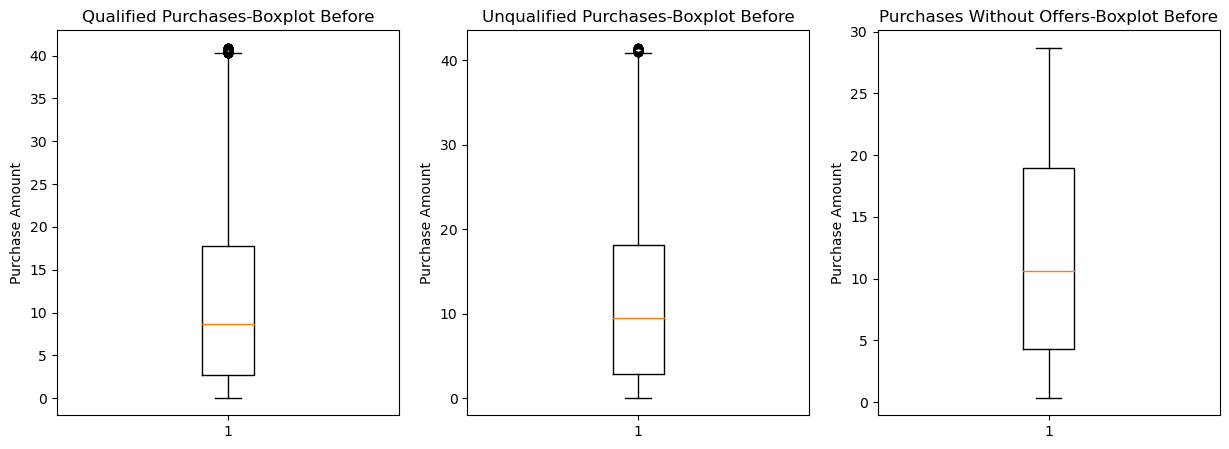

In [75]:
# Boxplot AFTER removing outliers for qualified_offers, purchaseWOOffer, and unqualified_purchase_DF
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))

# qualified_offers - Histogram
ax1.boxplot(qualified_offers["purchase_amount"])
ax1.set_title("Qualified Purchases-Boxplot Before")
ax1.set_ylabel('Purchase Amount')

# unqualified_purchase_DF - Boxplot
ax2.boxplot(unqualified_purchase_DF["purchase_amount"])
ax2.set_title("Unqualified Purchases-Boxplot Before")
ax2.set_ylabel('Purchase Amount')

# purchaseWOOffer - Boxplot
ax3.boxplot(purchaseWOOffer["purchase_amount"])
ax3.set_title('Purchases Without Offers-Boxplot Before')
ax3.set_ylabel('Purchase Amount')

plt.show()

### Now let's merge all three purchase dataframes so that can be used in the models. Keeping all variables from qualified_offers:

In [76]:
# qualified_offers with aggrgated purchase amount
pqualdf = qualified_offers
info_on_df(pqualdf)

# purchaseWOOffer with aggrgated purchase amount; add the required columns with default values
pWfrdf = pd.DataFrame({
    'person':
    purchaseWOOffer['person'].unique(),
    'value_offer_id':
    0,
    'reward':
    0,
    'difficulty':
    0,
    'duration':
    0,
    'email':
    0,
    'social':
    0,
    'mobile':
    0,
    'web':
    0,
    'OfrTyp_bogo':
    0,
    'OfrTyp_discount':
    0,
    'OfrTyp_informational':
    0,
    'time':
    0,
    'purchase_amount':
    purchaseWOOffer.groupby('person')['purchase_amount'].sum().values,
    'purchase_type':
    'withoutOffer'
})
info_on_df(pWfrdf)

# unqualified_purchase_DF with aggrgated purchase amount
punqdf = pd.DataFrame({
    'person':
    unqualified_purchase_DF['person'].unique(),
    'value_offer_id':
    0,
    'reward':
    0,
    'difficulty':
    0,
    'duration':
    0,
    'email':
    0,
    'social':
    0,
    'mobile':
    0,
    'web':
    0,
    'OfrTyp_bogo':
    0,
    'OfrTyp_discount':
    0,
    'OfrTyp_informational':
    0,
    'time':
    0,
    'purchase_amount':
    unqualified_purchase_DF.groupby('person')['purchase_amount'].sum().values,
    'purchase_type':
    'unqualified'
})
info_on_df(punqdf)

# Concatenate all three dataframes into one df
tagged_purchaseDF = pd.concat([pqualdf, pWfrdf, punqdf], axis=0)
tagged_purchaseDF.reset_index(inplace=True, drop=True)
tagged_purchaseDF.info()

# drop the time feature since not needed anymore.
tagged_purchaseDF_clean = tagged_purchaseDF.drop(['time'], axis=1)

print("\ntagged_purchaseDF_clean.info:")
tagged_purchaseDF_clean.info()

print("\ntagged_purchaseDF_clean sums:")
tagged_purchaseDF_clean.sum(numeric_only=True)

------------------------------------
Shape of DataFrame: (120786, 15)
Columns of DataFrame: Index(['person', 'time', 'value_offer_id', 'reward', 'difficulty', 'duration',
       'mobile', 'web', 'email', 'social', 'OfrTyp_bogo', 'OfrTyp_discount',
       'OfrTyp_informational', 'purchase_amount', 'purchase_type'],
      dtype='object')
------------------------------------
Shape of DataFrame: (6, 15)
Columns of DataFrame: Index(['person', 'value_offer_id', 'reward', 'difficulty', 'duration', 'email',
       'social', 'mobile', 'web', 'OfrTyp_bogo', 'OfrTyp_discount',
       'OfrTyp_informational', 'time', 'purchase_amount', 'purchase_type'],
      dtype='object')
------------------------------------
Shape of DataFrame: (9376, 15)
Columns of DataFrame: Index(['person', 'value_offer_id', 'reward', 'difficulty', 'duration', 'email',
       'social', 'mobile', 'web', 'OfrTyp_bogo', 'OfrTyp_discount',
       'OfrTyp_informational', 'time', 'purchase_amount', 'purchase_type'],
      dtype='ob

reward                    617648.00
difficulty               1164105.00
duration                21659256.00
mobile                    113556.00
web                       104357.00
email                     120786.00
social                     90113.00
OfrTyp_bogo                58478.00
OfrTyp_discount            69284.00
OfrTyp_informational       16370.00
purchase_amount          1528680.43
dtype: float64

In [77]:
# Let's look at the summary stats
tagged_purchaseDF_clean.describe(include='all')

,person,value_offer_id,reward,difficulty,duration,mobile,web,email,social,OfrTyp_bogo,OfrTyp_discount,OfrTyp_informational,purchase_amount,purchase_type
count,130168,130168,130168.000000,130168.000000,130168.000000,130168.000000,130168.000000,130168.000000,130168.000000,130168.00000,130168.000000,130168.000000,130168.000000,130168
unique,16574,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
top,8dbfa485249f409aa223a2130f40634a,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,qualified
freq,36,26603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120786
mean,NaN,NaN,4.745006,8.943097,166.394628,0.872380,0.801710,0.927924,0.692282,0.44925,0.532266,0.125761,11.743903,NaN
std,NaN,NaN,3.474706,5.592439,67.466731,0.333667,0.398713,0.258615,0.461551,0.49742,0.498960,0.331581,10.916493,NaN
min,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.050000,NaN
25%,NaN,NaN,2.000000,5.000000,120.000000,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,2.830000,NaN
50%,NaN,NaN,5.000000,10.000000,168.000000,1.000000,1.000000,1.000000,1.000000,0.00000,1.000000,0.000000,8.990000,NaN
75%,NaN,NaN,10.000000,10.000000,240.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,0.000000,18.290000,NaN


# ------------------------------------------------------------------------------------
## Next combine tagged purchase data with customer profile data

In [78]:
# merge tagged_purchaseDF_clean with profileDF_clean
combineddf1 = tagged_purchaseDF_clean.merge(profileDF_clean,
                                            how='inner',
                                            left_on=["person"],
                                            right_on=["id"],
                                            sort=True)
# reset index on resulting dataframe
combineddf1.reset_index(inplace=True, drop=True)

# drop the id column since we are keeping person column
combineddf1.drop(['id'], axis=1, inplace=True)

print(combineddf1.shape)
print("Total purchase Amount in combineddf1 =",
      combineddf1['purchase_amount'].sum())

# Let's see if there are any missing values in combineddf1
create_missing_values_table(combineddf1)

# Save combineddf1 to csv file
combineddf1.to_csv("combineddf1.csv")

(130168, 50)
Total purchase Amount in combineddf1 = 1528680.43
Your selected dataframe has 50 columns.
----------------------------------------------------
There are 0 columns that have missing values.


<AxesSubplot: title={'center': 'Purchase Amounts by cluster stacked by Purchase Type'}, xlabel='cluster'>

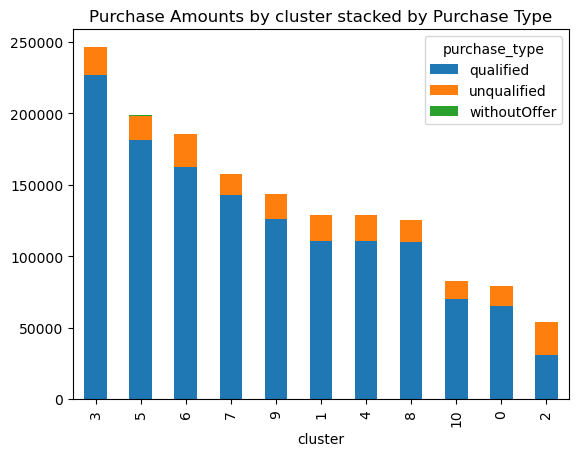

In [79]:
# Analyze combineddf1 that has customer profile and purchase data by plotting
purch_by_cluster = combineddf1.groupby(['cluster', 'purchase_type'
                                        ])['purchase_amount'].sum()
purch_by_cluster = purch_by_cluster.unstack()

# print(purch_by_cluster.columns)
purch_by_cluster = purch_by_cluster.sort_values(by='qualified',
                                                ascending=False)
purch_by_cluster.plot(
    kind='bar',
    stacked=True,
    title='Purchase Amounts by cluster stacked by Purchase Type')

#### Cluster4(shown as 3 above) has the total highest qualified purchase, followed by cluster6 (shown as 5 above) and cluster7 (shown as 6 above). We have already seen the make-up of these clusters earlier
- cluster4 has dominant features, tenure of more than a years, female, age group 60-70 years and income 50K-60K;
- cluster6 has dominant features, age group from 50 to 60-year old females with tenure over a year
- cluster7 has dominant features, male, age group 50-60 years, tenure of 270 or more days, and income 60K-70K

In [80]:
def keep_numeric_columns(df):
    """
    Utility function to keep only numeric columns in a given dataframe for regression analysis
    Input:
        df (pandas dataframe): the input dataframe from which to keep numeric variables
    Returns:
        df (pandas dataframe): the output dataframe which only contains numeric variables
    """
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    print("Number of Numeric columns in the dataset = ", len(numeric_columns))

    return df[numeric_columns]

In [81]:
# Convert tagged_purchaseDF purchase_type categorical var to dummies and concat to combineddf1
# NOTE we are not using create_dummy_variables function

combineddf2 = pd.concat([
    combineddf1,
    pd.get_dummies(tagged_purchaseDF["purchase_type"], prefix='purchase')
],
                        axis=1)

# Drop purchase_type categorical var since we have dummies
combineddf2.drop(['purchase_type'], axis=1, inplace=True)

info_on_df(combineddf2)

------------------------------------
Shape of DataFrame: (130168, 52)
Columns of DataFrame: Index(['person', 'value_offer_id', 'reward', 'difficulty', 'duration',
       'mobile', 'web', 'email', 'social', 'OfrTyp_bogo', 'OfrTyp_discount',
       'OfrTyp_informational', 'purchase_amount', 'income_0_20k',
       'income_20_30k', 'income_30_40k', 'income_40_50k', 'income_50_60k',
       'income_60_70k', 'income_70_80k', 'income_80_90k', 'income_90_100k',
       'income_100_110k', 'income_110_120k', 'income_120+', 'tenure_days_0_30',
       'tenure_days_30_60', 'tenure_days_60_90', 'tenure_days_90_120',
       'tenure_days_120_150', 'tenure_days_150_180', 'tenure_days_180_210',
       'tenure_days_210_240', 'tenure_days_240_270', 'tenure_days_270_365',
       'tenure_days_365+', 'gender_F', 'gender_M', 'gender_O', 'gender_U',
       'age_0_20y', 'age_20_30y', 'age_30_40y', 'age_40_50y', 'age_50_60y',
       'age_60_70y', 'age_70_100y', 'age_100+', 'cluster',
       'purchase_qualified', '

# ===========================================================

# 4. Modeling

Now that we have completed data preprocessing, we will select models for business questions. We will test different models and immediately evaluate the model response, and provide a deployment approach, if applicable to test with new data point.

Initially to find **factors** that can help predict purchase amount, which is a numerical response variable, we will consider two regression models. We will observe a model suggesting to use a set most features to use vs. another model suggesting selective most important features to predict purchase amount for a customer.

* Linear Regression model with recursive approach to find the best variables for the model,
* LassoCV model that will eliminate variables and also perform five-fold cross-validation. 

In [82]:
def select_important_columns(df, responseCol="", featureKnt=20):
    '''
    This function uses feature importance from Linear Regressor to identify the top n columns that are most important for 
    predicting a given response variable. It returns a list of predictor columns.
    Parameters:
        df: Dataframe on which to run the LinearRegression model
        responseCol: string response variable in the input dataframe
        featureKnt : Maximum number of features to return as predictors
    Returns:
        list: List of predictor columns 
    '''

    X = df.drop(responseCol, axis=1)
    y = df[responseCol]
    model = LinearRegression()
    rfe = RFE(model, n_features_to_select=featureKnt)
    rfe.fit(X, y)
    return X.columns[rfe.support_]

In [83]:
# Now let's run the function above and see what are the important predictors for the purchase_amount
combineddf2_with_all_columns = keep_numeric_columns(combineddf2).drop([
    'cluster', 'purchase_qualified', 'purchase_unqualified',
    'purchase_withoutOffer'
],
                                                                      axis=1)

# limit on number of predictors
numPredictors = 50

importantPredictors = select_important_columns(combineddf2_with_all_columns,
                                               "purchase_amount",
                                               numPredictors)

# print top predictors
print("Top ", numPredictors, " Important Predictors of Purchase Amount are:\n",
      list(importantPredictors))

Number of Numeric columns in the dataset =  50
Top  50  Important Predictors of Purchase Amount are:
 ['reward', 'difficulty', 'duration', 'mobile', 'web', 'email', 'social', 'OfrTyp_bogo', 'OfrTyp_discount', 'OfrTyp_informational', 'income_0_20k', 'income_20_30k', 'income_30_40k', 'income_40_50k', 'income_50_60k', 'income_60_70k', 'income_70_80k', 'income_80_90k', 'income_90_100k', 'income_100_110k', 'income_110_120k', 'income_120+', 'tenure_days_0_30', 'tenure_days_30_60', 'tenure_days_60_90', 'tenure_days_90_120', 'tenure_days_120_150', 'tenure_days_150_180', 'tenure_days_180_210', 'tenure_days_210_240', 'tenure_days_240_270', 'tenure_days_270_365', 'tenure_days_365+', 'gender_F', 'gender_M', 'gender_O', 'gender_U', 'age_0_20y', 'age_20_30y', 'age_30_40y', 'age_40_50y', 'age_50_60y', 'age_60_70y', 'age_70_100y', 'age_100+']


#### Let's try the second model, Lasso Regression with Cross Validation. Lasso Regession is used when number of predictors is high. Cross validation will rotate the data in the train and test datasets by splitting them first. First define a function:

In [84]:
def select_predictors_LassoCV(data, response):
    '''
    This function first removes the response variable from the list of predictors, then creates the feature matrix X and
    target variable y. It then initializes the LassoCV model with 5-fold cross-validation and normalization. It then fits
    the model to the data and gets the indices of the non-zero coefficients. Finally, the function returns a list of the
    predictors with non-zero coefficients.
    Parameters 
        data = dataframe on which to run the model
        response = response variable
    returns
        list of nonzero_predictors        
    '''
    predictors = data.columns.tolist()
    predictors.remove(response)
    X = data[predictors]
    y = data[response]

    # Initialize the pipeline, first scale then lasso with 5-fold cross validation
    pipeline = Pipeline([('scaler', StandardScaler()),
                         ('lasso', LassoCV(cv=5, precompute=False))])

    # Fit the pipeline to the data
    pipeline.fit(X, y)

    print("The LassoCV Score (R^2) = ", np.round(pipeline.score(X, y), 2))

    # Get the indices of the non-zero coefficients
    nonzero_coef_indices = np.nonzero(pipeline.named_steps['lasso'].coef_)[0]

    # Get the names of the predictors with non-zero coefficients
    nonzero_predictors = [predictors[i] for i in nonzero_coef_indices]

    return nonzero_predictors

In [85]:
# Lets' call the function above that runs LassoCV.
predictors_list = select_predictors_LassoCV(combineddf2_with_all_columns,
                                            "purchase_amount")
print("Important", len(predictors_list),
      " Predictors by Lasso Cross Validation Model:\n", predictors_list)

The LassoCV Score (R^2) =  0.38
Important 34  Predictors by Lasso Cross Validation Model:
 ['reward', 'difficulty', 'mobile', 'email', 'social', 'OfrTyp_informational', 'income_20_30k', 'income_30_40k', 'income_40_50k', 'income_50_60k', 'income_70_80k', 'income_80_90k', 'income_90_100k', 'income_100_110k', 'income_110_120k', 'tenure_days_0_30', 'tenure_days_30_60', 'tenure_days_60_90', 'tenure_days_90_120', 'tenure_days_120_150', 'tenure_days_150_180', 'tenure_days_180_210', 'tenure_days_210_240', 'tenure_days_270_365', 'tenure_days_365+', 'gender_F', 'gender_O', 'gender_U', 'age_0_20y', 'age_20_30y', 'age_30_40y', 'age_50_60y', 'age_60_70y', 'age_70_100y']


### Model evaluation: 

Linear Regression model suggested to use nearly **all** predictors up to the (supplied) limit whereas LassoCV model gave **34** important predictors of its own. With 34 features, LassCV regression model can explain 38% of the variance. Note all demographics features, income, age, tenure, and gender have been bin-ed and mapped to clusters which we can use in subsequent model, instead of using all 50+ features.

### -------------------------------------------------------------------------------------------------------------------------------------------------------
### Modeling: (Q1) Let's now build different regression models to predict the purchase amount based on demographics and offer type. We will start with creating train and test data sets.

In [86]:
def create_train_test_datasets(df, response_var):
    '''
    Utility function to keep only the predictors in the X, and response in y and split the data into train and test
    Parameters:
    df : DataFrame to be split into train and test datasets 
    response_var : response variable column name in the df
    Returns:
    X_train, X_test, y_train, y_test : 4 dataframes
    '''

    X = df.drop([response_var], axis=1)
    print("\nDimensions of X are:", X.ndim)
    print("Shape of X is", X.shape)
    print("Size of X is", X.size)

    # keep only the response variables in y
    # change the response to 1 or 0 for logistics regression # y =  combineddf3_purch_clstrs["value_amount"].apply(lambda q: 1 if q > 0 else 0)
    y = df[response_var]
    print("\nDimensions of y are:", y.ndim)
    print("Shape of y is", y.shape)
    print("Size of y is", y.size)
    printf(y.head())

    # let's split the data as train test
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        train_size=0.8,
                                                        random_state=42)

    y_train.columns = [response_var]
    y_test.columns = [response_var]

    # let's check the train test split results
    print("\nX_train Dim are:", X_train.ndim, "Shape=", X_train.shape,
          "Size =", X_train.size)
    print("y_train Dim are:", y_train.ndim, "Shape=", y_train.shape, "Size =",
          y_train.size)
    print("X_test  Dim are:", X_test.ndim, "Shape=", X_test.shape, "Size =",
          X_test.size)
    print("y_test  Dim are:", y_test.ndim, "Shape=", y_test.shape, "Size =",
          y_test.size)

    return X_train, X_test, y_train, y_test

In [87]:
# Since we already have the clusters assigned using the demographics attributes, we can only use the clusters and drop
# the other demographic  attributes.
combineddf3cluster = combineddf2[[
    'cluster', 'reward', 'difficulty', 'duration', 'social', 'mobile', 'email',
    'web', 'OfrTyp_bogo', 'OfrTyp_discount', 'OfrTyp_informational',
    'purchase_qualified', 'purchase_unqualified', 'purchase_withoutOffer',
    'purchase_amount'
]]
info_on_df(combineddf3cluster)

------------------------------------
Shape of DataFrame: (130168, 15)
Columns of DataFrame: Index(['cluster', 'reward', 'difficulty', 'duration', 'social', 'mobile',
       'email', 'web', 'OfrTyp_bogo', 'OfrTyp_discount',
       'OfrTyp_informational', 'purchase_qualified', 'purchase_unqualified',
       'purchase_withoutOffer', 'purchase_amount'],
      dtype='object')


In [88]:
# call the function to create train and test datasets
X_train, X_test, y_train, y_test = create_train_test_datasets(
    combineddf3cluster[[
        'cluster', 'reward', 'difficulty', 'duration', 'social', 'mobile',
        'email', 'web', 'OfrTyp_bogo', 'OfrTyp_discount',
        'OfrTyp_informational', 'purchase_amount'
    ]], "purchase_amount")


Dimensions of X are: 2
Shape of X is (130168, 11)
Size of X is 1431848

Dimensions of y are: 1
Shape of y is (130168,)
Size of y is 130168
0    22.16
1     8.57
2    14.11
3    13.56
4    10.27
Name: purchase_amount, dtype: float64

X_train Dim are: 2 Shape= (104134, 11) Size = 1145474
y_train Dim are: 1 Shape= (104134,) Size = 104134
X_test  Dim are: 2 Shape= (26034, 11) Size = 286374
y_test  Dim are: 1 Shape= (26034,) Size = 26034


### -------------------------------------------------------------------------------------------------------------------------------------------------------
### Let's build a RandomForestRegressor model first to predict the purchase amount and the features that are  important to the prediction:


 Feature importances for the RandomForestRegressor model
                       feature_importance
cluster                         0.688675
reward                          0.006731
difficulty                      0.006565
duration                        0.137590
social                          0.009442
mobile                          0.001771
email                           0.134560
web                             0.001889
OfrTyp_bogo                     0.003804
OfrTyp_discount                 0.002341
OfrTyp_informational            0.006634


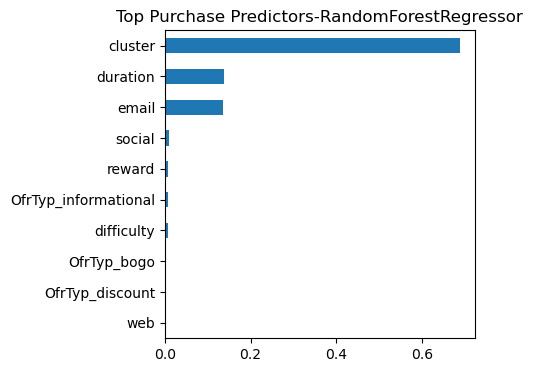

In [89]:
# RandomForestRegressor
clf_rfr = RandomForestRegressor(n_estimators=500,
                                n_jobs=4,
                                random_state=45,
                                verbose=0)
clf_rfr.fit(X_train, y_train)

# Create a dataframe for plotting feature_importance
clf_rfr_df = pd.DataFrame({"feature_importance": clf_rfr.feature_importances_},
                          index=clf_rfr.feature_names_in_)

# print feature importances for the rfr model
print("\n Feature importances for the RandomForestRegressor model\n",
      clf_rfr_df)

# Sort feature_importance in descending order of value
clf_rfr_df.sort_values(by="feature_importance", ascending=True, inplace=True)

# plot the chart for Top Purchase Predictors-RandomForestRegressor
clf_rfr_df.tail(10).plot.barh(
    figsize=(4, 4),
    legend=False,
    title="Top Purchase Predictors-RandomForestRegressor")

X_test_combined = pd.concat([X_test, y_test], axis=1)

# Let's predict the test dataset on the RFR model
yPred = clf_rfr.predict(X_test)

### Notice from above chart, according to the Random Forest Regressor model, to predict customer purchase, the top predictors by importance are: customer's demographic cluster, offer duration, email and social media as a channel for the offer delivery. Other predictors' importance is relatively very small compared to these top 3. Next we evaluate the RandomForestRegressor model performance using metrics such as mean absolute error, R-squared, and adjusted R-squared.

In [90]:
# calculate mean absolute error, R-squared, and adjusted R-squared for the RandomForestRegressor

# score from the RF model for the training data
clf_rfr.score(X_train, y_train)

# calculate mean squared error
mse = mean_squared_error(y_test, yPred)

# calculate Mean Absolute Error error
mae = abs(yPred - y_test).mean()
r2 = r2_score(y_test, yPred)
n = X_test.shape[0]
p = X_test.shape[1]
adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)
print('RandomForestRegressor Train Data R-squared:', np.round(r2, 3))
print('RandomForestRegressor Test Data R-squared:', np.round(r2, 3))
print('RandomForestRegressor Test Data Mean Absolute Error:', np.round(mae, 3))
print("RandomForestRegressor Test Data Mean Squared Error:", np.round(mse,3))
print('RandomForestRegressor Test Data Adjusted R-squared:',
      np.round(adj_r2, 3))

RandomForestRegressor Train Data R-squared: 0.197
RandomForestRegressor Test Data R-squared: 0.197
RandomForestRegressor Test Data Mean Absolute Error: 7.25
RandomForestRegressor Test Data Mean Squared Error: 96.401
RandomForestRegressor Test Data Adjusted R-squared: 0.197


### Model Evaluation - RandomForestRegressor :

- The R-squared value of **0.197** for both the train and test data means that only **19.70%** of the variance in the target variable is explained by the features in the model. Generally an R-squared value of 0.197 is not very high, and the model's performance may be improved by trying different models or feature selection techniques.

- The train and test data R-squared are same, which indicates the model well-fit such that unknown test data point will have consistent prediction.

- The Mean Absolute Error of **7.25** indicates that, on average, the model's predictions are off by about **$7.25**.

To improve the performance of the model on the test data, we can consider tuning the hyperparameters of Random Forest Regressor model, or using a different algorithm altogether. Perhaps the distribution of the purchase amount in the test dataset is not similar to the distribution in the training dataset, as differences in the distribution can lead to poor model performance. Let's explore another **LassoCV** model to improve the performance.

### Let's train and evaluate another, LassoCV regression model to predict the purchase amount:

In [91]:
# LassoCV regression model
# get the X and y ready

X = combineddf3cluster.copy()
X.drop(["purchase_amount"], axis=1, inplace=True)
print("\nDimensions of X are:", X.ndim)
print("Shape of X is", X.shape)
print("Size of X is", X.size)

# keep only the response variables in y
y = combineddf2["purchase_amount"]
print("\nDimensions of y are:", y.ndim)
print("Shape of y is", y.shape)
print("Size of y is", y.size)
y.head()

# list of predictors
predictors = X.columns.tolist()

# Initialize the pipeline
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('lasso', LassoCV(cv=5, precompute=False))])

# Fit the pipeline to the entire dataset
pipeline.fit(X, y)

# Get the indices of the non-zero coefficients
nonzero_coef_indices = np.nonzero(pipeline.named_steps['lasso'].coef_)[0]

# Get the names of the predictors with non-zero coefficients
nonzero_predictors = [predictors[i] for i in nonzero_coef_indices]

# predict the response variable
y_pred = pipeline.predict(X)

# Compute the mean squared error, R^2 score, and Mean Absolute Error error
mse = round(mean_squared_error(y, y_pred),3)
r2 = round(r2_score(y, y_pred),3)
mae = round(abs(y_pred - y).mean(),3)

print('\nLassoCV Regression model Mean Absolute Error:', mae)
print('\nLassoCV Regression model Mean Squared Error:', mse)
print('LassoCV Regression model R^2 Score:', r2)


Dimensions of X are: 2
Shape of X is (130168, 14)
Size of X is 1822352

Dimensions of y are: 1
Shape of y is (130168,)
Size of y is 130168

LassoCV Regression model Mean Absolute Error: 8.412

LassoCV Regression model Mean Squared Error: 111.668
LassoCV Regression model R^2 Score: 0.063


### Model Evaluation (CRISP-DM #5) - LassoCV Regressor:
The LassoCV regression model has a **Mean Absolute Error** of 8.41, which indicates that, on average, the model's predictions are off by about **\$8.41**. And the **Mean Squared Error of 111.66** which indicates that the model has a relatively high error on average. The **R^2 score of 0.06**  indicates that the model explains only about **6%** of the variability in the data, which is relatively low. Overall, the model may not be a good fit for the data, and we may need to consider other models.
The LassoCV Regression model has **R^2 Score of 0.06** which is **lower** as than what we saw (0.2) for the **RandomForestRegressor** model earlier.

 ### Let's try another, Gradient Boosting Regressor (GBR) model (CRISP-DM #4) to predict the purchase amount. GBR model has two parameters "learning rate" and "depth" that can be tweaked for better performance.

In [92]:
# define the function
def train_gbr(X_train,
              y_train,
              X_test,
              y_test,
              learning_rate=0.1,
              n_estimators=100,
              max_depth=3):
    """
    Trains a Gradient Boosting Regressor on the given training data and evaluates its performance on the test data.
    Parameters:
    X_train (numpy.ndarray): Array of shape (n_samples, n_features) containing the training input data.
    y_train (numpy.ndarray): Array of shape (n_samples,) containing the target values for the training data.
    X_test (numpy.ndarray): Array of shape (n_samples, n_features) containing the test input data.
    y_test (numpy.ndarray): Array of shape (n_samples,) containing the target values for the test data.
    learning_rate (float, optional): The learning rate shrinks the contribution of each tree by learning_rate. 
        There is a trade-off between learning_rate and n_estimators.
    n_estimators (int, optional): The number of boosting stages to perform. Gradient boosting is fairly robust 
        to over-fitting so a large number usually results in better performance.
    max_depth (int, optional): Maximum depth of each individual tree estimator.
    Returns:
    (float, float, float, gbr): Tuple containing the mean squared error, R-squared score, mean absolute error, of the 
    trained model on the test data, and Gradient Boosting Regressor model.
    """
    # Initialize the Gradient Boosting Regressor
    gbr = GradientBoostingRegressor(learning_rate=learning_rate,
                                    n_estimators=n_estimators,
                                    max_depth=max_depth)

    # Fit the model to the training data
    gbr.fit(X_train, y_train)

    # Evaluate the model on the test data
    y_pred = gbr.predict(X_test)
    mse = round(mean_squared_error(y_test, y_pred), 3)
    r2 = round(r2_score(y_test, y_pred), 3)
    mae = round(abs(y_test - y_pred).mean(), 3)

    return mse, r2, mae, gbr

In [93]:
# see if different learning rates yield better performance for the Gradient Boosting Regressor model
print(
    "\nSee if different learning rates yield better performance for the GBR model:"
)

learning_rates = [0.1, 0.05, 0.01, 0.005]
results = {}

for lr in learning_rates:
    mse, r2, mae, gbr = train_gbr(X_train, y_train, X_test, y_test, lr)
    results[lr] = (mse, r2, mae)

# Sort the results by R^2 score in descending order
sorted_results = sorted(results.items(), key=lambda x: x[1][1], reverse=True)

# Print the results
for lr, (mse, r2, mae) in sorted_results:
    print(
        f"GBR Learning Rate:{lr}, Mean Squared Error:{mse}, R^2 Score:{r2}, Mean Absolute Error:{mae}")

print("\nSee if different depths yield better performance for the GBR model:")
# see if different depths yield better performance for the Gradient Boosting Regressor model
depths = [3, 4, 5, 6, 7, 8]
results = {}

for dp in depths:
    mse, r2, mae, gbr = train_gbr(X_train, y_train, X_test, y_test, max_depth=dp)
    results[dp] = (mse, r2, mae)

# Sort the results by R^2 score in descending order
sorted_results = sorted(results.items(), key=lambda x: x[1][1], reverse=True)

# Print the results
for dp, (mse, r2, mae) in sorted_results:
    print(f"GBR Max Depth:{dp}, Mean Squared Error:{mse}, R^2 Score:{r2}, Mean Absolute Error:{mae}")


See if different learning rates yield better performance for the GBR model:
GBR Learning Rate:0.1, Mean Squared Error:96.329, R^2 Score:0.198, Mean Absolute Error:7.263
GBR Learning Rate:0.05, Mean Squared Error:96.766, R^2 Score:0.194, Mean Absolute Error:7.313
GBR Learning Rate:0.01, Mean Squared Error:103.989, R^2 Score:0.134, Mean Absolute Error:7.823
GBR Learning Rate:0.005, Mean Squared Error:108.374, R^2 Score:0.097, Mean Absolute Error:8.053

See if different depths yield better performance for the GBR model:
GBR Max Depth:3, Mean Squared Error:96.329, R^2 Score:0.198, Mean Absolute Error:7.263
GBR Max Depth:4, Mean Squared Error:96.248, R^2 Score:0.198, Mean Absolute Error:7.251
GBR Max Depth:5, Mean Squared Error:96.243, R^2 Score:0.198, Mean Absolute Error:7.247
GBR Max Depth:6, Mean Squared Error:96.269, R^2 Score:0.198, Mean Absolute Error:7.246
GBR Max Depth:7, Mean Squared Error:96.316, R^2 Score:0.198, Mean Absolute Error:7.247
GBR Max Depth:8, Mean Squared Error:96.34

### Model Evaluation (CRISP-DM #5) - Gradient Boosting Regressor (GBR)  

The results show that the GBR model has better performance with **the max depth of 5**, with the lowest mean squared error **96.24** and the highest R-squared score **.198** among the tested depths. Mean Absolute Error:7.247 indicates that, on average, the model's predictions are off by about \$7.25.  The learning rate of 0.1 also performed relatively well but with slightly worse results than the of the max depth of 5.

Different **learning rates** did not yield better performance for the GBR model.

### Comparing all three models above:
- Random Forest Regressor model      MSE=96.401,   R^2=0.2, and MAE=7.25
- LassoCV Regressor model            MSE=111.66,   R^2=0.062, and MAE=8.41
- Gradient Boosting Regressor model  MSE=96.243,   R^2=0.198, and MAE=7.247

Comparing the R-squared scores, the all models performed equally. However, using at the Mean Squared Error (MSE), we can see that the **Gradient Boosting Regressor** model had the lowest MSE, indicating that it may have better accuracy in predicting the response variable, purchase_amount.

### So knowing which cluster a customer belongs to, the offer type, offer delivery channel, etc. we can determine how much customer will purchase using the Gradient Boosting Regressor model. See demonstration below:

In [94]:
# lr = 0.05 Set learning rate to 0.05 and get an instance of GBR
dp=5 # set max rate to 5 and get an instance of GBR

mse, r2, mae, gbr = train_gbr(X_train, y_train, X_test, y_test, max_depth=dp)
print("Gradient Boosting Regressor Model MSE=", mse, "R^2=", r2, "MAE=", mae)

# Save the model to a file
filepath = 'GradientBoostingRegressor.pkl'
save_model(gbr, filepath)

Gradient Boosting Regressor Model MSE= 96.243 R^2= 0.198 MAE= 7.247


### Deployment (CRISP-DM \#6) Approach for Gradient Boosting Regressor  model
#### This Gradient Boosting Regressor  model can be saved to a pickle file which can be used for batch deployment to predict purchase amount for a cluster with offer attributes, as demonstrated below:

In [95]:
# set up a data point to test the GBR with; we will use a record from training data
obs_no = 5555
print("A data point with cluster and offer attributes=")
print(X_train.iloc[obs_no])
xdata1 = X_train.iloc[obs_no]
print("Same data point array=", X_train.iloc[obs_no].values)
print("Purchase Amount in Train Data=", y_train.values[obs_no])

A data point with cluster and offer attributes=
cluster                   0
reward                   10
difficulty               10
duration                168
social                    1
mobile                    1
email                     1
web                       1
OfrTyp_bogo               1
OfrTyp_discount           1
OfrTyp_informational      0
Name: 25817, dtype: int64
Same data point array= [  0  10  10 168   1   1   1   1   1   1   0]
Purchase Amount in Train Data= 11.14


In [96]:
# import joblib
# load model from file
gbr_model = joblib.load('GradientBoostingRegressor.pkl')

# Use existing data point above to test with or tweak

# Build a test cluster record with specific values
xdata1 = pd.DataFrame([((4 ,  2  ,10 ,168,   0,   1 ,  1  , 1 ,  0  , 1 ,  0))],
                      columns=[
                          'cluster', 'reward', 'difficulty', 'duration',
                          'social', 'mobile', 'email', 'web', 'OfrTyp_bogo',
                          'OfrTyp_discount', 'OfrTyp_informational'
                      ])

# predict purchase amount on test data point above
y_pred = gbr_model.predict(xdata1)
print("Predicted Purchase amount=", np.round(y_pred[0], 2))
print("Purchase Amount in Train Data=", y_train.values[obs_no])

Predicted Purchase amount= 11.27
Purchase Amount in Train Data= 11.14


### -------------------------------------------------------------------------------------------------------------------------------------------------------
### Modeling (CRISP-DM #4) to determine which demographic groups (clusters) respond best to which offer types (Q2)

Below we are creating **Decision Tree Classifier model to predict clusters for new offer types**. Intent is that the model will predict a closest cluster that will respond to a new offer using similar offers from the training data and their associated clusters. Remember clusters are groups of **similar** customers based on Income, Gender, Age and Tenure. Offer characteristics define an offer.

In [97]:
# Define features and target for classification model
# Create train and test datasets, reponse variable is cluster; y_train_pred and y_test_pred would be predicted clusters
# Considering 'purchase_qualified', 'purchase_unqualified','purchase_withoutOffer' as predictors as we purchase history.
# for NEW customers, can set these features to 0 for predicting a cluster.

X_train_dmg, X_test_dmg, y_train_dmg, y_test_dmg = create_train_test_datasets(
    combineddf3cluster[[
        'reward', 'difficulty', 'duration', 'social', 'mobile', 'email', 'web',
        'OfrTyp_bogo', 'OfrTyp_discount', 'OfrTyp_informational', 'cluster',
        'purchase_qualified', 'purchase_unqualified', 'purchase_withoutOffer'
    ]], "cluster")

print("X_train_dmg columns:", X_train_dmg.columns)
print("y_train_dmg columns:", y_train_dmg.columns)


Dimensions of X are: 2
Shape of X is (130168, 13)
Size of X is 1692184

Dimensions of y are: 1
Shape of y is (130168,)
Size of y is 130168
0    10
1    10
2    10
3    10
4    10
Name: cluster, dtype: int32

X_train Dim are: 2 Shape= (104134, 13) Size = 1353742
y_train Dim are: 1 Shape= (104134,) Size = 104134
X_test  Dim are: 2 Shape= (26034, 13) Size = 338442
y_test  Dim are: 1 Shape= (26034,) Size = 26034
X_train_dmg columns: Index(['reward', 'difficulty', 'duration', 'social', 'mobile', 'email', 'web',
       'OfrTyp_bogo', 'OfrTyp_discount', 'OfrTyp_informational',
       'purchase_qualified', 'purchase_unqualified', 'purchase_withoutOffer'],
      dtype='object')
y_train_dmg columns: ['cluster']


In [98]:
# Train the model
dt_classifier = DecisionTreeClassifier(max_depth=50,
                                       random_state=42) 

# Tried tuning these hyperparameters, to improve the performance of the decision 
# treesplitter='best', criterion='gini', class_weight='balanced'

dt_classifier.fit(X_train_dmg, y_train_dmg)

# Test the model
y_pred_dmg = dt_classifier.predict(X_test_dmg)

# Evaluate the model
print("Decision Tree Model classification Report:")
print(classification_report(y_test_dmg, y_pred_dmg, zero_division=0))

Decision Tree Model classification Report:
              precision    recall  f1-score   support

           0       0.13      0.02      0.04      2265
           1       0.08      0.00      0.01      1890
           2       0.12      0.17      0.14      2762
           3       0.14      0.78      0.23      3412
           4       0.09      0.00      0.01      2321
           5       0.13      0.01      0.01      2243
           6       0.13      0.07      0.09      3028
           7       0.30      0.00      0.00      1827
           8       0.14      0.00      0.00      1895
           9       0.15      0.00      0.01      2410
          10       0.05      0.00      0.00      1981

    accuracy                           0.13     26034
   macro avg       0.13      0.10      0.05     26034
weighted avg       0.13      0.13      0.06     26034



### Model Evaluation (CRISP-DM #5) - Decision Tree classification Model
The classification report shows 11 classes on each for of 11 clusters in the train & test (X) dataset. For each class, we see the precision, recall, F1-score and no. of observations supporting that prediction. As we can see, max precision of 50% is estimated for class 4 (cluster 4) but F1-score is 0,  which indicates that the model did not perform well in identifying instances for that cluster. Max F-1 score is .23 for class 3 (cluster 3) and remaining F1-scores are really low. Overall accuracy of the model is just **13%**. 
To improve the performance of the decision, tried tuning these hyperparameters, treesplitter='best', criterion='gini', class_weight='balanced', but they did not help.

### Model deployment(CRISP-DM\#6) Decision Tree classification
Below we demonstrated how to use Decision Tree classification Model on one data point from train dataset:


In [99]:
# let's get a sample record to test with dt_classifier model to predict cluster
obs_no = 10
X_train_dmg.iloc[obs_no]
X_train_dmg.iloc[obs_no].values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=int64)

In [100]:
# For new offer data point, predict a cluster that will respond better
new_data = pd.DataFrame([[5, 5, 168, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0]])
new_data.columns = X_train_dmg.columns

preds = dt_classifier.predict(new_data)
print("Predicted Cluster:", preds[0], "Actual Cluster in Training Data:",
      y_train_dmg.values[obs_no])

Predicted Cluster: 3 Actual Cluster in Training Data: 1


The Predicted Cluster and Actual Cluster in training data do not match, we already knew the model's performance only 13% accurate.

### --------------------------------------------------------------------------------------------------------------------------------------------------------
### Modeling (CRISP-DM\#5) RandomForestClassifier to predict binary response to a new offer, if a purchase will be  qualified (within the offer duration), unqualified or without-offer.

In [101]:
# Q3: build a model that predicts predict binary response to a new offer, if a purchase will be qualified (within the offer
# duration), unqualified or without-offer.
# split data into training and test sets for selected features

X_train, X_test, y_train, y_test = train_test_split(combineddf3cluster[[
    'reward', 'difficulty', 'duration', 'social', 'mobile', 'email', 'web',
    'OfrTyp_bogo', 'OfrTyp_discount', 'OfrTyp_informational'
]],
                                                    combineddf3cluster[[
                                                        'purchase_qualified',
                                                        'purchase_unqualified',
                                                        'purchase_withoutOffer'
                                                    ]],
                                                    test_size=0.3,
                                                    random_state=42)

# Print the class distribution of y_train and y_test
print("Qualified Purchase distribution of y_train:")
print(y_train.value_counts(normalize=True))
print("\nQualified Purchase distribution of y_test:")
print(y_test.value_counts(normalize=True))

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit random forest classification model; changed n_estimators several times to settle on 500.
rfc_model1 = RandomForestClassifier(n_estimators=500, random_state=42)

# Perform 5-fold cross-validation on the training set and calculate the mean score
rfc_model1_scores = cross_val_score(rfc_model1, X_train, y_train, cv=5)
rfc_model1_mean_score = np.mean(rfc_model1_scores)

# Train the model on the entire training set and evaluate on the testing set
rfc_model1.fit(X_train, y_train)
rfc_model1_test_score = rfc_model1.score(X_test, y_test)

print("\nRandomForestClassifier Mean cross-validation score:",
      rfc_model1_mean_score)
print("RandomForestClassifier Test set score:", rfc_model1_test_score)

# Predict on test set and calculate classification report
y_pred = rfc_model1.predict(X_test)
rfc_model1_report = classification_report(y_test, y_pred, zero_division=0)

print("\n RandomForestClassifier classification Report:\n", rfc_model1_report)

# evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy of RandomForestClassifier Model on test dataset:", accuracy)

Qualified Purchase distribution of y_train:
purchase_qualified  purchase_unqualified  purchase_withoutOffer
1                   0                     0                        0.927302
0                   1                     0                        0.072643
                    0                     1                        0.000055
dtype: float64

Qualified Purchase distribution of y_test:
purchase_qualified  purchase_unqualified  purchase_withoutOffer
1                   0                     0                        0.929374
0                   1                     0                        0.070600
                    0                     1                        0.000026
dtype: float64

RandomForestClassifier Mean cross-validation score: 0.9273022532957584
RandomForestClassifier Test set score: 0.9293744078256638

 RandomForestClassifier classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96     36293
          

### Model Evaluation (CRISP-DM #5) of Random Forest Classifier:


The mean cross-validation score of the model is **0.927**, which indicates that the model has a good performance since it did 5-fold cross-validation during the training phase.

The **test set score of the model is 0.929**, which indicates that the model has a good predictive performance on new data.

The classification report shows the **precision, recall, and f1-score** of the model for each class (Qualified Purchase, Unqualified purchase, and Purchase without offer)in the dataset. The precision for **class 0 (Qualified Purchase) is 0.93**, which means that 93% of the predicted instances for class 0 (Qualified Purchase) were correct. However, the **precision** for classes 1 (unqualified purchase) and 2 (purchase without offer) are both 0, which indicates that the model did not predict any instances correctly for those classes.

The **recall for class 0 (Qualified Purchase) is 1**, which means that the model correctly identified all instances of Qualified Purchase in the dataset. But, the recall for purchase_unqualified and purchase_withoutOffer (classes 1 and 2) are both 0, which indicates that the model did not correctly identify any instances for them. 

The **f1-score** is a harmonic mean of precision and recall, and it provides a balanced measure of the model's performance. The **f1-score for **class 0 (Qualified Purchase) 0.96**, which indicates that the model performed well in identifying Qualified Purchase. However, the **f1-score** for purchase_unqualified and purchase_withoutOffer (classes 1 and 2) are both 0, which indicates that the model did not perform well in identifying instances for them.

The **Micro avg score of precision, recall, and f1-score** represents the **overall performance** of the model across all classes(Qualified Purchase, Unqualified purchase, and Purchase without offer), which is **0.93**. 

The **Macro avg score of precision, recall, and f1-score** represents the **average performance** of the model across all classes, which is 0.31, 0.33, and 0.32 respectively. 

The **Weighted avg score of precision, recall, and f1-score** represents the **weighted average of the performance** of the model across all classes, which considers the number of instances for each class. It is **0.86, 0.93 and 0.89** for each of the class respectively.

The **Samples avg score of precision, recall, and f1-score** represents the **multilabel classification performance** of the model, which is **0.93**.

### ---------------------------------------------------------------------------------------------------------------------------------------------------
### Modeling LogisticRegression - to predict whether or not someone will respond to an offer within the offer-duration, that is will make qualified purchase. 

Similar to above Random Forest classification, but we only doing this for qualified offer and demonstrating all the wayt to deployment  to create a customer dataset for campaign:

We will now (Q3) build a **Logistic Regression classification model to predict whether or not someone will respond to an offer**. In this case, response is qualified purchase within the offer duration by the customer. 

Qualified Purchase distribution of y_train:
purchase_qualified
1                     0.927302
0                     0.072698
dtype: float64

Qualified Purchase distribution of y_test:
purchase_qualified
1                     0.929374
0                     0.070626
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Logistic Regression Model Coefficients in descending order:
difficulty: 0.03
social: 0.03
web: 0.03
reward: 0.02
OfrTyp_informational: 0.01
mobile: 0.01
duration: -0.01
OfrTyp_discount: -0.02
OfrTyp_bogo: -0.03
email: -0.04

Accuracy of Logistic Regression Model on test dataset: 0.9293744078256638


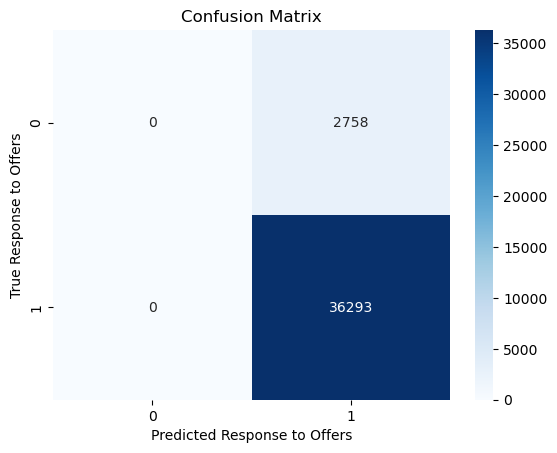

In [102]:
# Q3: build a model that predicts whether or not someone will respond to an offer.
# Working version1
# split data into training and test sets
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    combineddf3cluster[[
        'reward', 'difficulty', 'duration', 'social', 'mobile', 'email', 'web',
        'OfrTyp_bogo', 'OfrTyp_discount', 'OfrTyp_informational'
    ]],
    combineddf3cluster[['purchase_qualified']],
    test_size=0.3,
    random_state=42)

# Print the class distribution of y_train and y_test
print("Qualified Purchase distribution of y_train:")
print(y_train.value_counts(normalize=True))
print("\nQualified Purchase distribution of y_test:")
print(y_test.value_counts(normalize=True))

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit a logistic regression model
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)

# Print the coefficients of the logistic regression model
clf_coefficents = clf.coef_[0]
# create a list of tuples containing coefficients and feature names
coef_tuples = list(
    zip(clf_coefficents, [
        'reward', 'difficulty', 'duration', 'social', 'mobile', 'email', 'web',
        'OfrTyp_bogo', 'OfrTyp_discount', 'OfrTyp_informational'
    ]))

# sort the list in descending order of coefficients
coef_tuples.sort(reverse=True)

# print coefficients and feature names in the sorted order
print("\nLogistic Regression Model Coefficients in descending order:")
for coef, feature in coef_tuples:
    print(f"{feature}: {coef:.2f}")

# Predict on X_test set on the Logistic Regression Model
y_pred = clf.predict(X_test)

# evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy of Logistic Regression Model on test dataset:", accuracy)

# compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Response to Offers")
plt.ylabel("True Response to Offers")
plt.show()

### Model Evaluation (CRISP-DM #5) : Logistic Regression classification model

- The distribution of qualified purchases is similar between the training and test sets, with around 34% of customers making a qualified purchase.
- The coefficients of the logistic regression model give an indication of the importance of each feature in predicting a qualified purchase. The features with the largest **positive coefficients are reward and OfrTyp_discount**, which means higher the reward or amount of the discount, higher is the probability of the qualified purchase (within the offer duration. 
- Features with the largest **negative coefficients are difficulty and mobile**, which means higher is the difficulty (threashold amount for purchase), lower is the probability of the qualified purchase. Somehow offers delivered via mobile channel have lower chance of qualified purchases, this is a surprising insight.

##### This suggests that customers are more likely to make a qualified purchase if they are offered a higher reward or a discount, and less likely to make a qualified purchase if the offer requires more effort or is only available on mobile.

- The **accuracy** of the logistic regression model on the **test dataset is around 65%**, which means that the model correctly predicted the outcome for 65% of the customers. 

However, it's important to keep in mind that accuracy is not always the best metric for evaluating a binary classification model, especially when the classes are imbalanced (as is the case here). Other metrics such as precision, recall, and F1-score may be more appropriate depending on the specific goals of the analysis.

### Model Deployment (CRISP-DM #6) - Logistic Regression Classification model

We can use above Logistics Regression model to create a target customer list for a new offer:

Let's create customer dataset by cartesian product between existing profile dataset with a new offer in "portfolio new" dataset so all customers will have that offer assigned. Then we will use this dataset to predict probability of purchase by each customer. Chosing customers with "purchase probability" greaten than specific threadhold, e.g., 0.5 will select those customers. This threadhold can be tweaked to limit the number of customers in the target list.

In [103]:
# KEEP # Let's create offer template using an existing offer
portfoliodf_NEW = portfoliodf_clean.head(1).copy()

# Change few offer parameters
portfoliodf_NEW = portfoliodf_NEW.assign(id="New Spring 2023 Discount Offer",
                                         reward=10,
                                         duration=7,
                                         difficulty=10,
                                         OfrTyp_informational=0,
                                         OfrTyp_discount=1,
                                         OfrTyp_bogo=0,
                                         social=1,
                                         mobile=1,
                                         web=1,
                                         email=1)
print("Sample New Offer:\n", portfoliodf_NEW)

# Create customer data by cartesian product between existing profile data above portfoliodf_NEW
customer_data = pd.merge(portfoliodf_NEW.assign(key=1),
                         profileDF_clean.assign(key=1),
                         on='key',
                         how='outer')

# drop the key column, rename id_y
customer_data = customer_data.drop(columns=['key']).rename(columns={
    "id_x": "offer_id",
    "id_y": "id"
})

info_on_df(customer_data)

# Use above datapoint to predict whether someone will respond to an offer, we can use it to create a target
# customer list by predicting the likelihood of a response for each customer in a new dataset created above.
# This code can be used for a new customer list/dataset.

# preprocess customer_data which contains new offer assigned to each customer
X = scaler.transform(customer_data[[
    'reward', 'difficulty', 'duration', 'social', 'mobile', 'email', 'web',
    'OfrTyp_bogo', 'OfrTyp_discount', 'OfrTyp_informational'
]])

# predict likelihood of response for each customer to the new offer
y_pred = clf.predict_proba(X)[:, 1]

# add predicted response probabilities to customer data
customer_data["response_probability"] = np.round(y_pred, 2)

# let's see how does the response_probability look
print("New Offer Response Probability customer_data shape:\n", customer_data.shape)

# filter for high-potential customers, this threshold can be tweaked
target_customers = customer_data[customer_data["response_probability"] > 0.5]
info_on_df(target_customers)

# export target customer list to CSV
target_customers.to_csv("target_customers.csv", index=False)

customer_data["response_probability"].describe()

Sample New Offer:
    reward  difficulty  duration                              id  mobile  web  \
0      10          10         7  New Spring 2023 Discount Offer       1    1   

   email  social  OfrTyp_bogo  OfrTyp_discount  OfrTyp_informational  
0      1       1            0                1                     0  
------------------------------------
Shape of DataFrame: (17000, 48)
Columns of DataFrame: Index(['reward', 'difficulty', 'duration', 'offer_id', 'mobile', 'web',
       'email', 'social', 'OfrTyp_bogo', 'OfrTyp_discount',
       'OfrTyp_informational', 'id', 'income_0_20k', 'income_20_30k',
       'income_30_40k', 'income_40_50k', 'income_50_60k', 'income_60_70k',
       'income_70_80k', 'income_80_90k', 'income_90_100k', 'income_100_110k',
       'income_110_120k', 'income_120+', 'tenure_days_0_30',
       'tenure_days_30_60', 'tenure_days_60_90', 'tenure_days_90_120',
       'tenure_days_120_150', 'tenure_days_150_180', 'tenure_days_180_210',
       'tenure_days_210_

count    1.700000e+04
mean     9.300000e-01
std      1.970704e-13
min      9.300000e-01
25%      9.300000e-01
50%      9.300000e-01
75%      9.300000e-01
max      9.300000e-01
Name: response_probability, dtype: float64

# Conclusion
###### Student adequately summarizes the end-to-end problem solution and discusses one or two particular aspects of the project they found interesting or difficult.

The data preprocessing phase was particularly time-consuming in this project. Deciding whether to retain or eliminate outliers from the dataset necessitated careful consideration of the business context, specific scenario, and expert judgement. We decided to retain the unknown gender category, which represented a substantial proportion of the customer base. Additionally, we chose to keep customers with longer tenure, even though they were outliers. When creating age bins, we utilized domain knowledge to group customers aged 70–100 together in a single category, rather than dividing them into three separate groups.
In terms of modeling, we evaluated multiple algorithms depending on the question of interest. For grouping the customers based on their demographics attributes age, income, gender and tenure, we used Kmeans clustering algorithm. For predicting the numerical response variable (i.e., purchase amount), we compared three regression models and determined that Gradient Boosting Regression outperformed the others. For classification tasks, we assessed Logistic Regression, Decision Tree Classifier, and Random Forest Classifier models. Our findings suggested that the quality of the data had the most significant impact on model performance. However, we were able to improve results by tuning some model parameters and trying different models. Finally we stopped at Random Forest Classifier model with best prediction results among all models we tried.


# Improvement

###### Discussion is made as to how at least one aspect of the implementation could be improved. Potential solutions resulting from these improvements are considered and compared/contrasted to the current solution.

The given transcript data has time dimension associated with the offers received, viewed and completed as well as the purchase transactions. In our current models we used the time dimension to identify purchase transactions as qualified or not depending on whether the purchase was made from offer receipt and the offer duration. Alternatively, we  could have used a Time Series model, such as ARIMA, to forecast customer purchase. This would involve analyzing the time series data of each customer's past purchase behavior over time and identifying any patterns or trends that may exist. With 17 thousand customers in the given profile, this may take significant resources, let alone millions of customers Starbucks has! 

Additionally, the current models in our solution could be made into an application, which will read the profile, transcript and portfolio datasets. It will preprocess, clean, and run clustering model, apply clusters, run Random Forest Classifier and for a new offer with specific characteristics such as reward, duration, difficulty, delivery channels, the application would provide a list of customers to send the offer to.